In [ ]:
import pandas as pd
import re

def plot_smoothed_curve(ax, csv_path, target_metric, window=300):
    df = pd.read_csv(csv_path)

    pattern = re.compile(r'^(.*?) - (.*?)(?:__(MIN|MAX))?$')
    renamed_cols = {}
    model_name = None
    detected_column = None

    for col in df.columns:
        if col == 'Step':
            renamed_cols[col] = 'episode'
        else:
            match = pattern.match(col)
            if match:
                model, metric, suffix = match.groups()
                if model_name is None:
                    model_name = model
                base_name = metric
                new_name = f'{base_name}_{suffix.lower()}' if suffix else base_name
                renamed_cols[col] = new_name
                if suffix is None and metric == target_metric:
                    detected_column = new_name
            else:
                renamed_cols[col] = col

    df = df.rename(columns=renamed_cols)

    if detected_column is None:
        raise KeyError(f"Could not find a column for metric '{target_metric}'. Found columns: {list(df.columns)}")

    df['roll_mean'] = df[detected_column].rolling(window, min_periods=1).mean()
    df['roll_std']  = df[detected_column].rolling(window, min_periods=1).std().fillna(0)

    ax.plot(df['episode'], df['roll_mean'], label=model_name)
    ax.fill_between(df['episode'],
                    df['roll_mean'] - df['roll_std'],
                    df['roll_mean'] + df['roll_std'],
                    alpha=0.2)


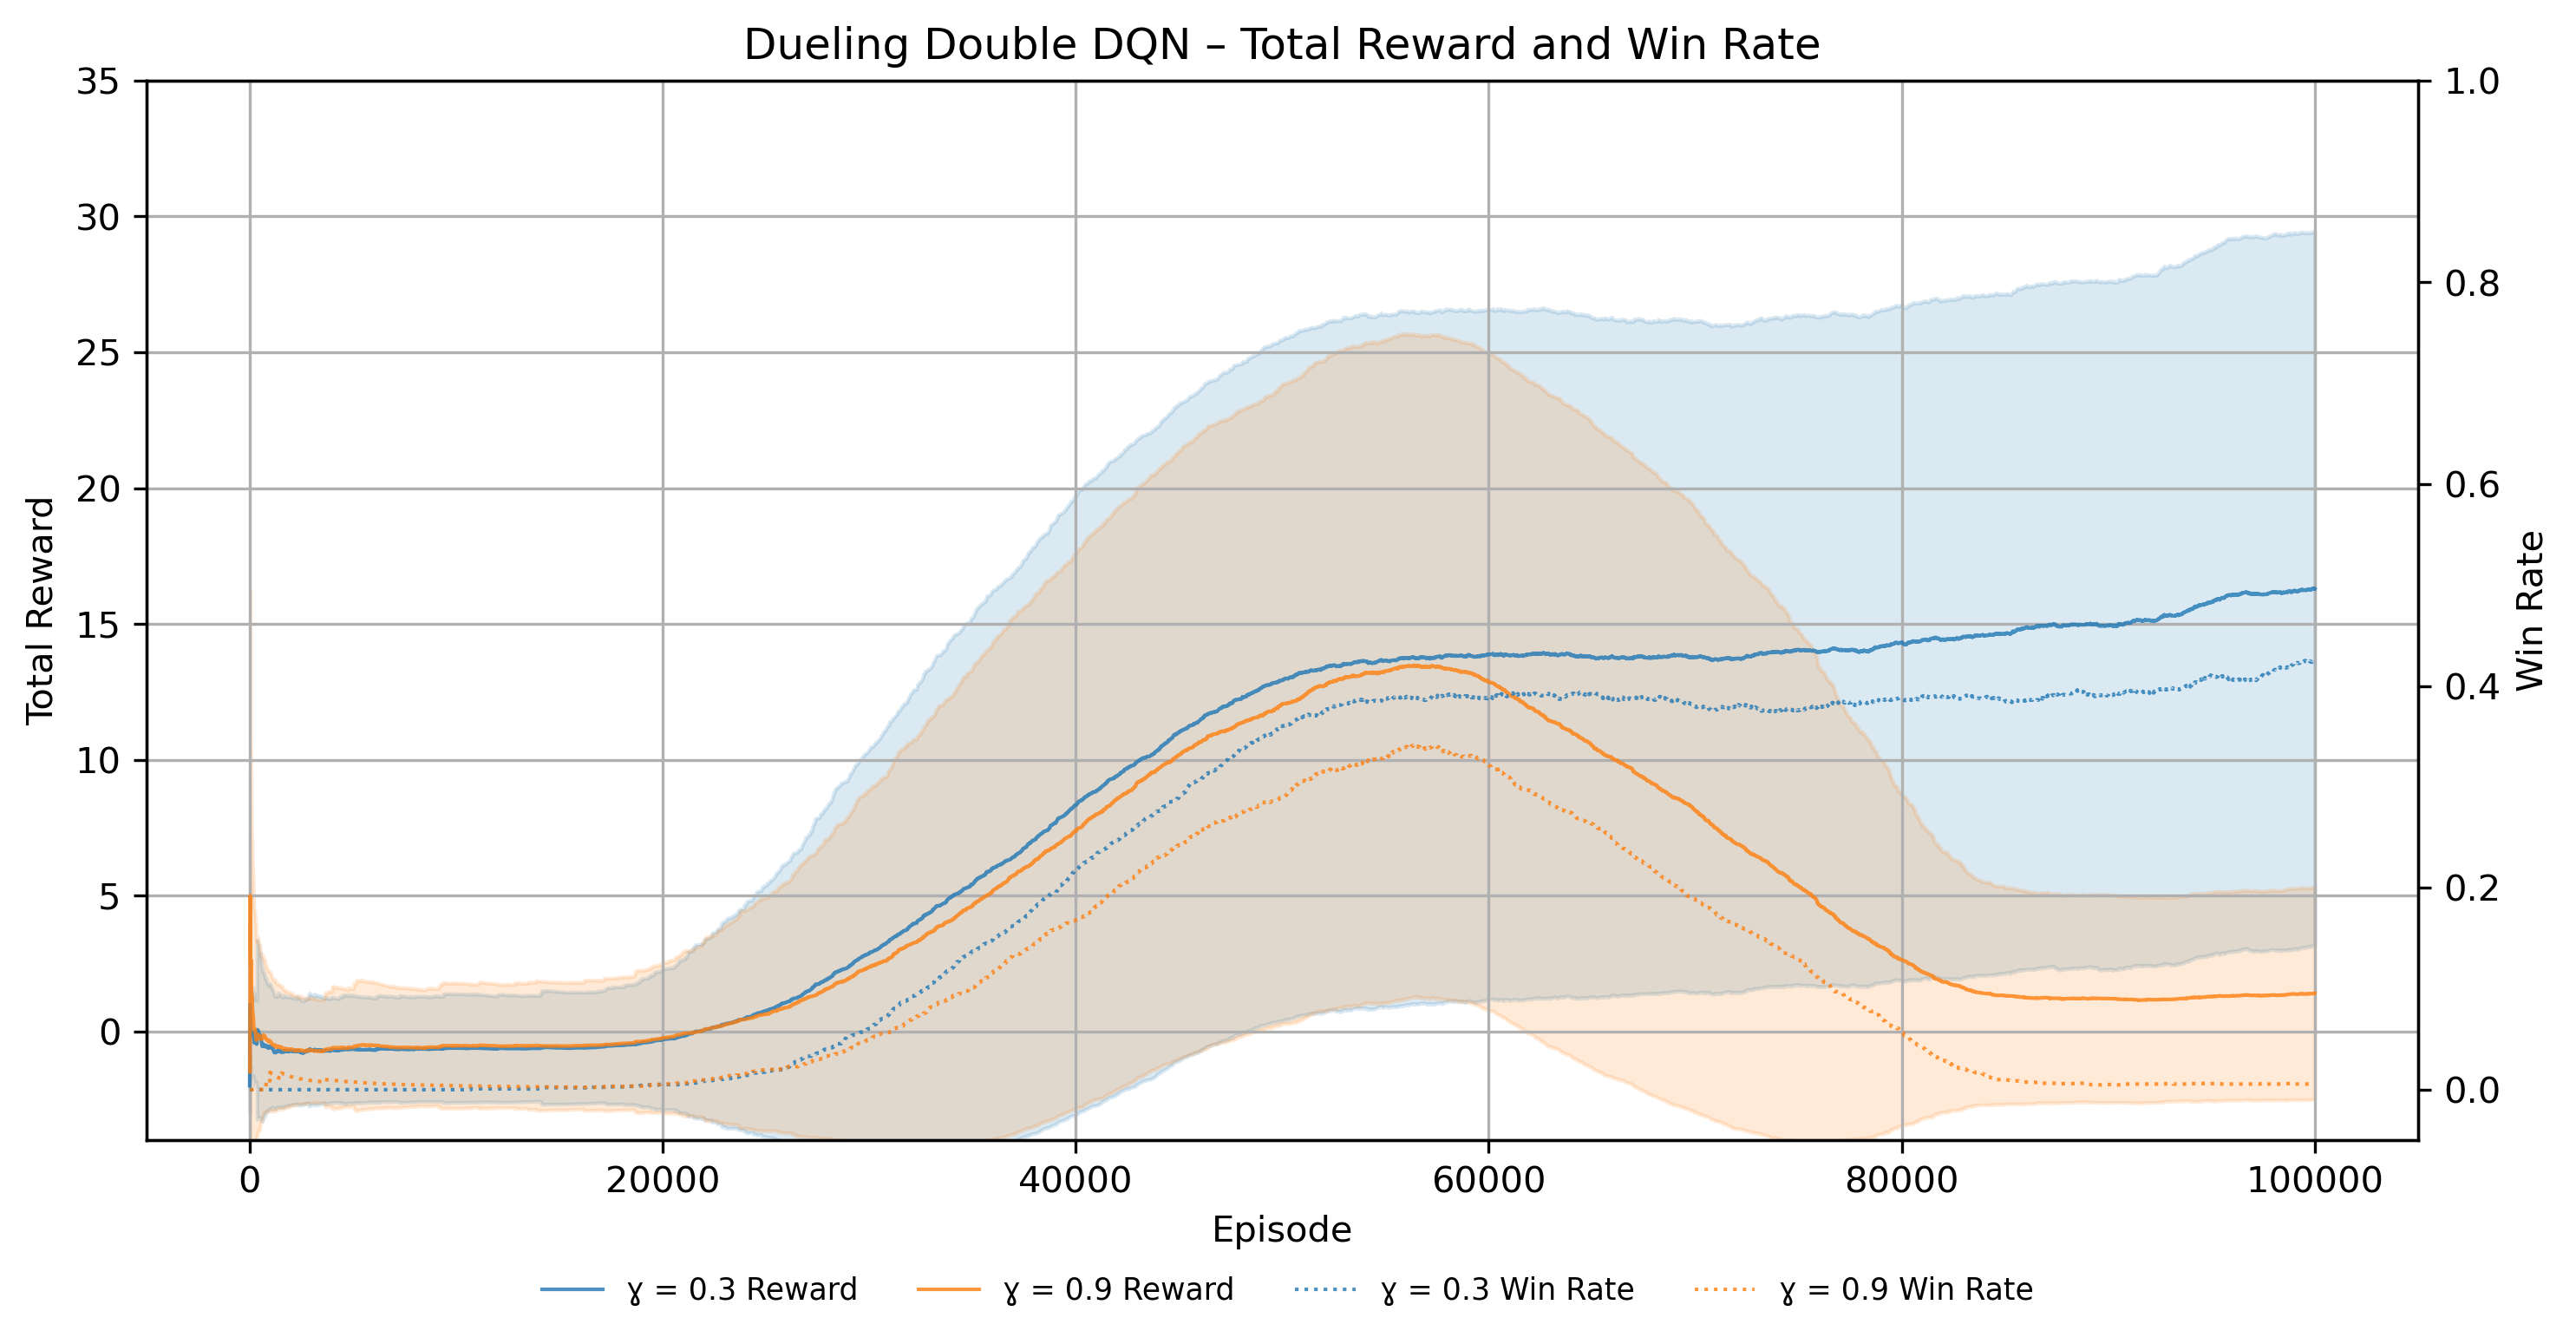

In [23]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

def plot_smoothed_curve(ax, csv_path, target_metric, window=300, show_std=True, color=None, label_suffix="", linestyle='-', lw=1, alpha=0.8):
    """
    Load CSV, parse columns like "Model - metric" and plot rolling mean (and std) on given axis.
    """
    df = pd.read_csv(csv_path)
    # Rename 'Step' to 'episode' and pattern match other columns
    pattern = re.compile(r'^(.*?) - (.*?)(?:__(MIN|MAX))?$')
    renamed_cols = {}
    model_name = None
    detected_column = None

    for col in df.columns:
        if col == 'Step':
            renamed_cols[col] = 'episode'
        else:
            match = pattern.match(col)
            if match:
                model, metric, suffix = match.groups()
                if model_name is None:
                    model_name = model
                base_name = metric.lower()
                new_name = f'{base_name}_{suffix.lower()}' if suffix else base_name
                renamed_cols[col] = new_name
                if suffix is None and metric == target_metric:
                    detected_column = new_name
            else:
                renamed_cols[col] = col

    df = df.rename(columns=renamed_cols)
    if detected_column is None:
        return

    # rolling statistics
    df['roll_mean'] = df[detected_column].rolling(window, min_periods=1).mean()
    df['roll_std']  = df[detected_column].rolling(window, min_periods=1).std().fillna(0)

    # plot line
    if model_name.startswith("non_det_DDQN_9"):
        model_name = "​ɣ = 0.9"
    if model_name.startswith("non_det_DDQN_3"):
        model_name = "​ɣ = 0.3"
    lbl = f"{model_name}{label_suffix}"
    ax.plot(df['episode'], df['roll_mean'], label=lbl, color=color, alpha=alpha, linewidth=lw, linestyle=linestyle)
    # plot std shading if desired
    if show_std:
        ax.fill_between(df['episode'],
                        df['roll_mean'] - df['roll_std'],
                        df['roll_mean'] + df['roll_std'],
                        alpha=alpha * 0.2, color=color)

# Merge into single plot with distinct alphas/lw
parent_folder = "results/NonDet"
fig, ax1 = plt.subplots(figsize=(10, 5), dpi=300)
ax2 = ax1.twinx()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_idx = 0

for folder_name in sorted(os.listdir(parent_folder)):
    full_path = os.path.join(parent_folder, folder_name)
    if not os.path.isdir(full_path) or folder_name in ["Q_learning", "DQN", "DDQN", "DDQN_disc", "DQN_disc"]:
        continue

    reward_path = os.path.join(full_path, "t_reward.csv")
    win_path    = os.path.join(full_path, "win.csv")
    col = colors[color_idx % len(colors)]

    # plot reward: lighter/dimmer
    if os.path.exists(reward_path):
        plot_smoothed_curve(ax1, reward_path, "total_reward",
                            window=2500, show_std=True,
                            color=col, label_suffix=" Reward",
                            linestyle='-')
    # plot win rate: darker/bolder
    if os.path.exists(win_path):
        plot_smoothed_curve(ax2, win_path, "win",
                            window=2500, show_std=False,
                            color=col, label_suffix=" Win Rate",
                            linestyle=':')
    color_idx += 1

# finalize
ax1.set_title("Dueling Double DQN – Total Reward and Win Rate")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward", color='black')
ax1.set_ylim(-4, 35)
ax2.set_ylabel("Win Rate", color='black')
ax2.set_ylim(-0.05, 1)

# combined legend
lines, labels = [], []
for ax in (ax1, ax2):
    l, lab = ax.get_legend_handles_labels()
    lines.extend(l)
    labels.extend(lab)
fig.legend(lines, labels,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.03),  # center below the plot
           ncol=len(labels),             # one column per label
           fontsize='small', frameon=False)
fig.tight_layout(rect=[0, 0.08, 1, 1])

ax1.grid(True)

fig.tight_layout()
plt.show()
fig.savefig("100k_comparison.png", bbox_inches='tight')


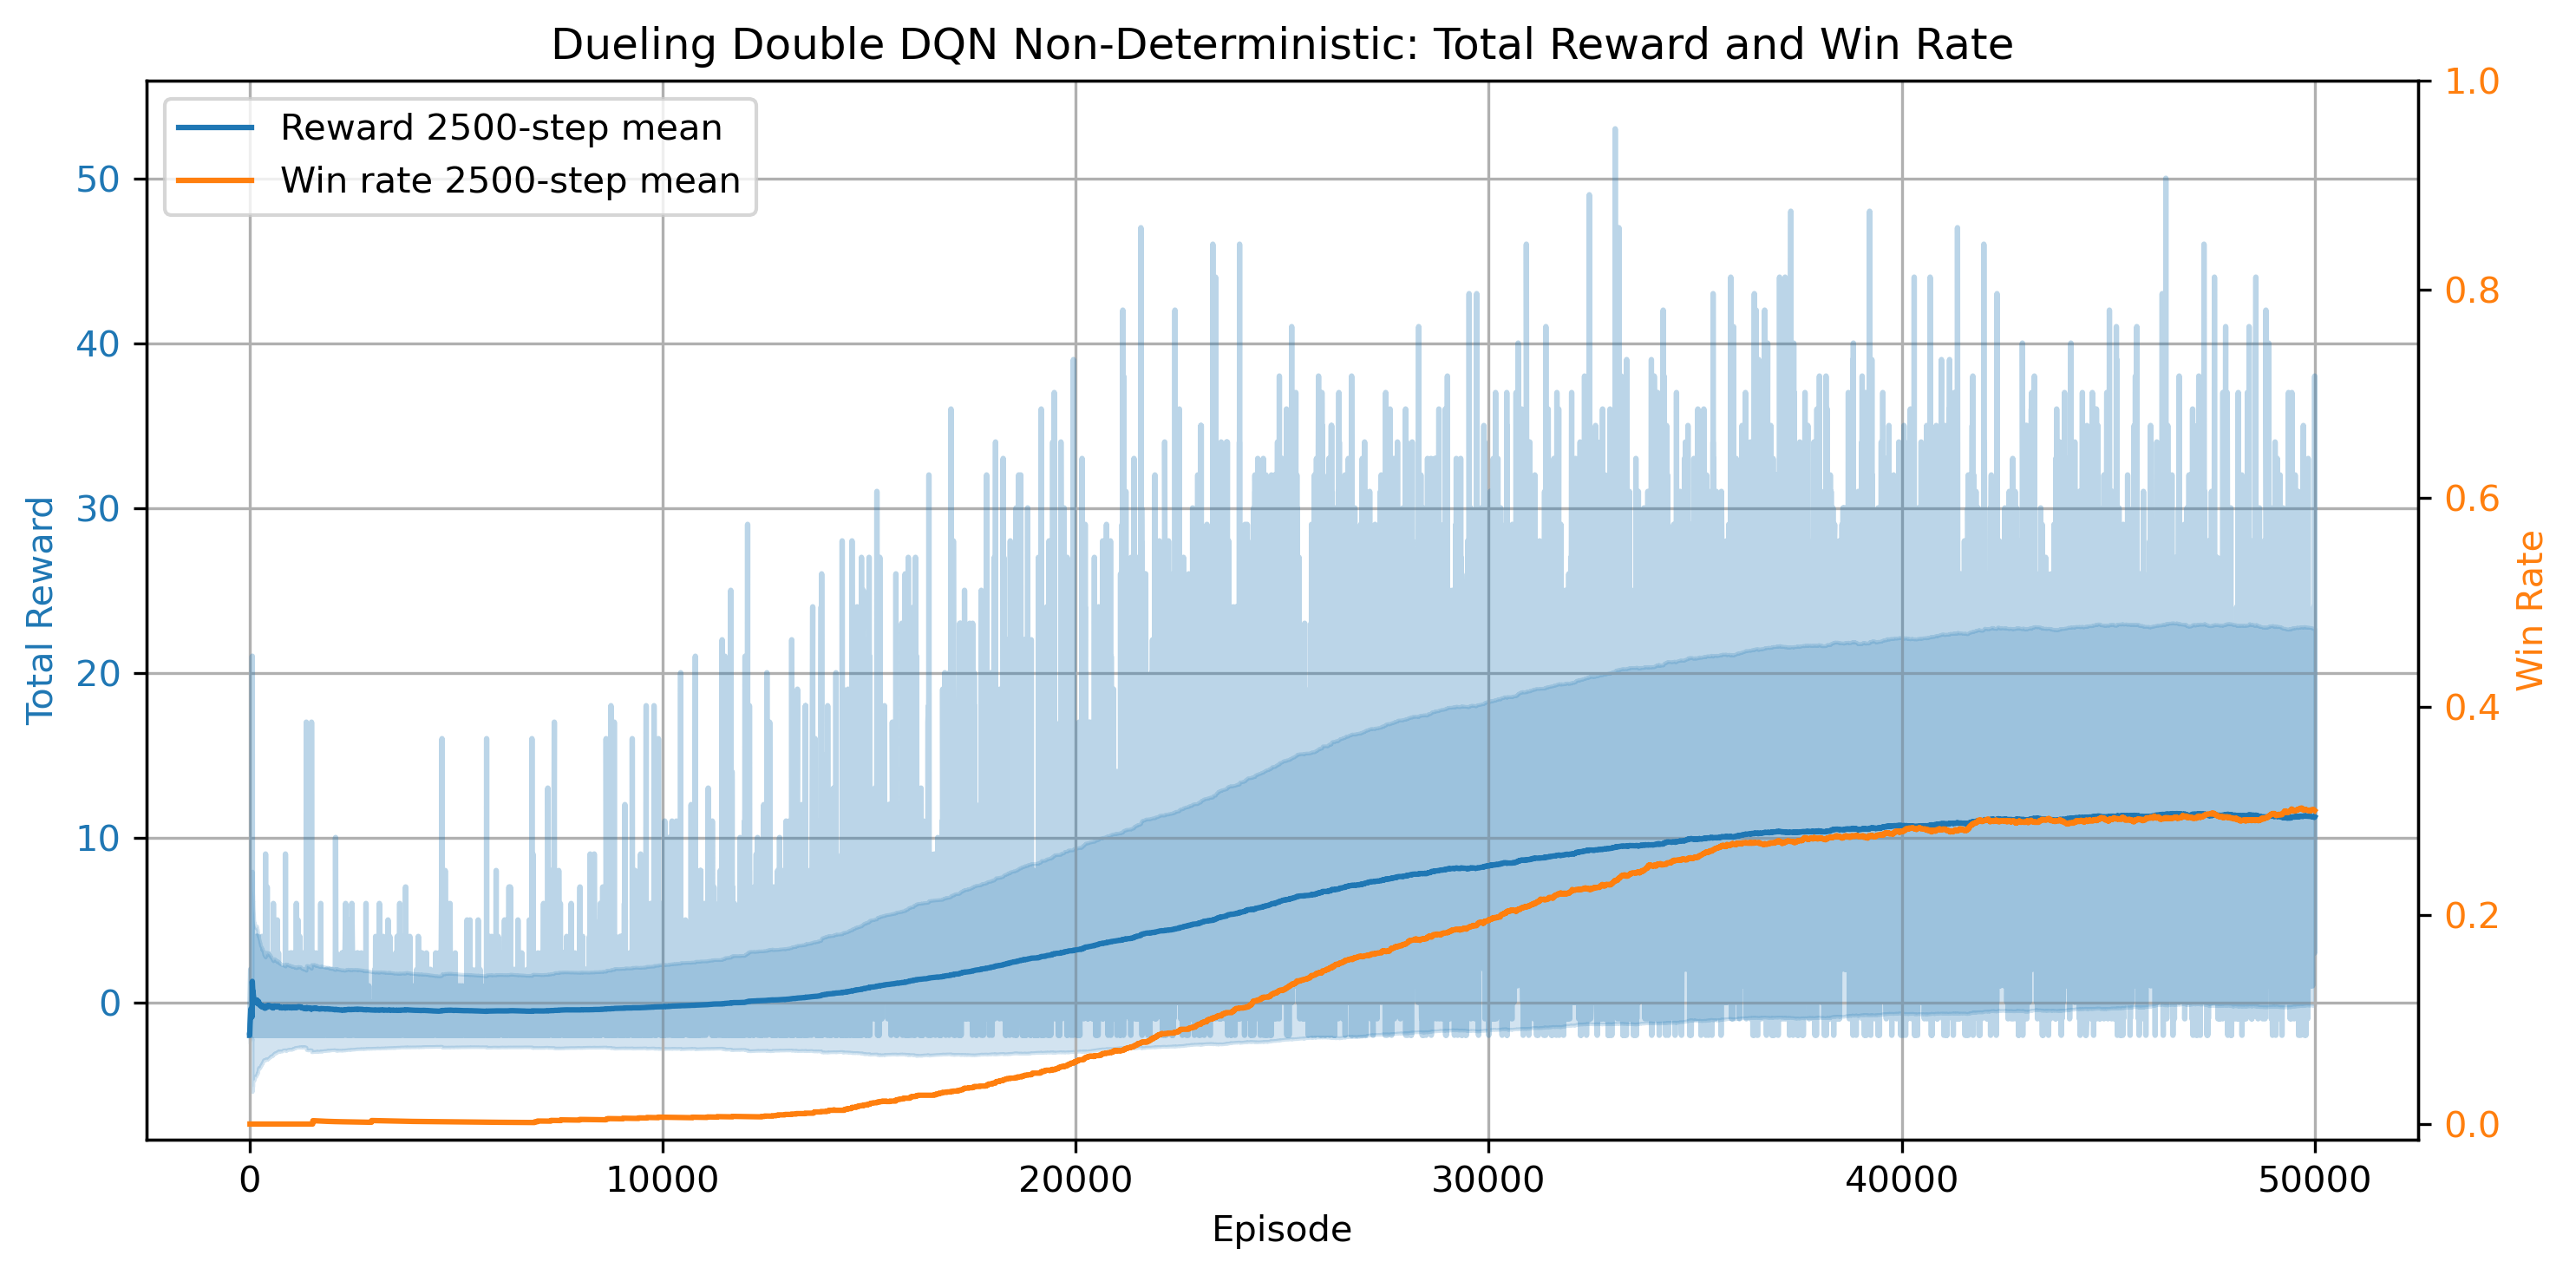

In [74]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

def load_and_parse(csv_path, target_metric, window):
    """
    Load CSV and parse columns like "Model - metric", "Model - metric__MIN", "Model - metric__MAX".
    Returns DataFrame with 'episode', raw metric, rolling mean, and rolling std.
    """
    df = pd.read_csv(csv_path)
    # Rename 'Step' to 'episode' and pattern match other columns
    pattern = re.compile(r'^(.*?) - (.*?)(?:__(MIN|MAX))?$')
    renamed = {}
    detected = None
    
    for col in df.columns:
        if col == 'Step':
            renamed[col] = 'episode'
        else:
            m = pattern.match(col)
            if m:
                model, metric, suff = m.groups()
                base = metric.lower()
                new = f"{base}_{suff.lower()}" if suff else base
                renamed[col] = new
                if suff is None and metric == target_metric:
                    detected = new
            else:
                renamed[col] = col
    
    df = df.rename(columns=renamed)
    if detected is None:
        raise KeyError(f"Metric '{target_metric}' not found in columns of {csv_path}")
    
    # Compute rolling stats
    df['roll_mean'] = df[detected].rolling(window, min_periods=1).mean()
    df['roll_std']  = df[detected].rolling(window, min_periods=1).std().fillna(0)
    
    return df[['episode', detected, 'roll_mean', 'roll_std']]

def plot_combined_reward_win(reward_csv, win_csv, window=300, figsize=(10,5), 
                             save_path=None, title=None, dpi=300, show_std=False):
    # Load and parse
    df_r = load_and_parse(reward_csv, 'total_reward', window)
    df_w = load_and_parse(win_csv, 'win', window)
    
    fig, ax1 = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Plot raw reward and std if requested
    if show_std:
        ax1.plot(df_r['episode'], df_r['total_reward'], 
                 alpha=0.3, label='Raw total_reward', color='tab:blue')
        ax1.fill_between(df_r['episode'],
                         df_r['roll_mean'] - df_r['roll_std'],
                         df_r['roll_mean'] + df_r['roll_std'],
                         alpha=0.2, color='tab:blue')
    
    # Plot reward rolling mean
    ln1 = ax1.plot(df_r['episode'], df_r['roll_mean'],
                   label=f'Reward {window}-step mean', color='tab:blue')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Win rate on right axis (no std)
    ax2 = ax1.twinx()
    ln2 = ax2.plot(df_w['episode'], df_w['roll_mean'],
                   label=f'Win rate {window}-step mean', color='tab:orange')
    ax2.set_ylabel('Win Rate', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylim(top=1)
    
    # Title, grid, legend
    if title:
        ax1.set_title(title)
    ax1.grid(True)
    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels, loc='best')
    
    fig.tight_layout()
    save_path = title.replace(' ', '_').lower() + '.png'
    if save_path:
        fig.savefig(save_path)
    plt.show()

model = 'DDQN_disc'
mode = 'NonDet'

if mode == 'Det':
    title = f'Deterministic: Total Reward and Win Rate'
else:
    title = f'Non-Deterministic: Total Reward and Win Rate'

# Example usage
plot_combined_reward_win(
    reward_csv=f'results/{mode}/{model}/t_reward.csv',
    win_csv=f'results/{mode}/{model}/win.csv',
    window=2500,
    figsize=(10,5),
    save_path='combined_reward_winrate.png',
    title=f'Dueling Double DQN {title}',
    show_std=True
)

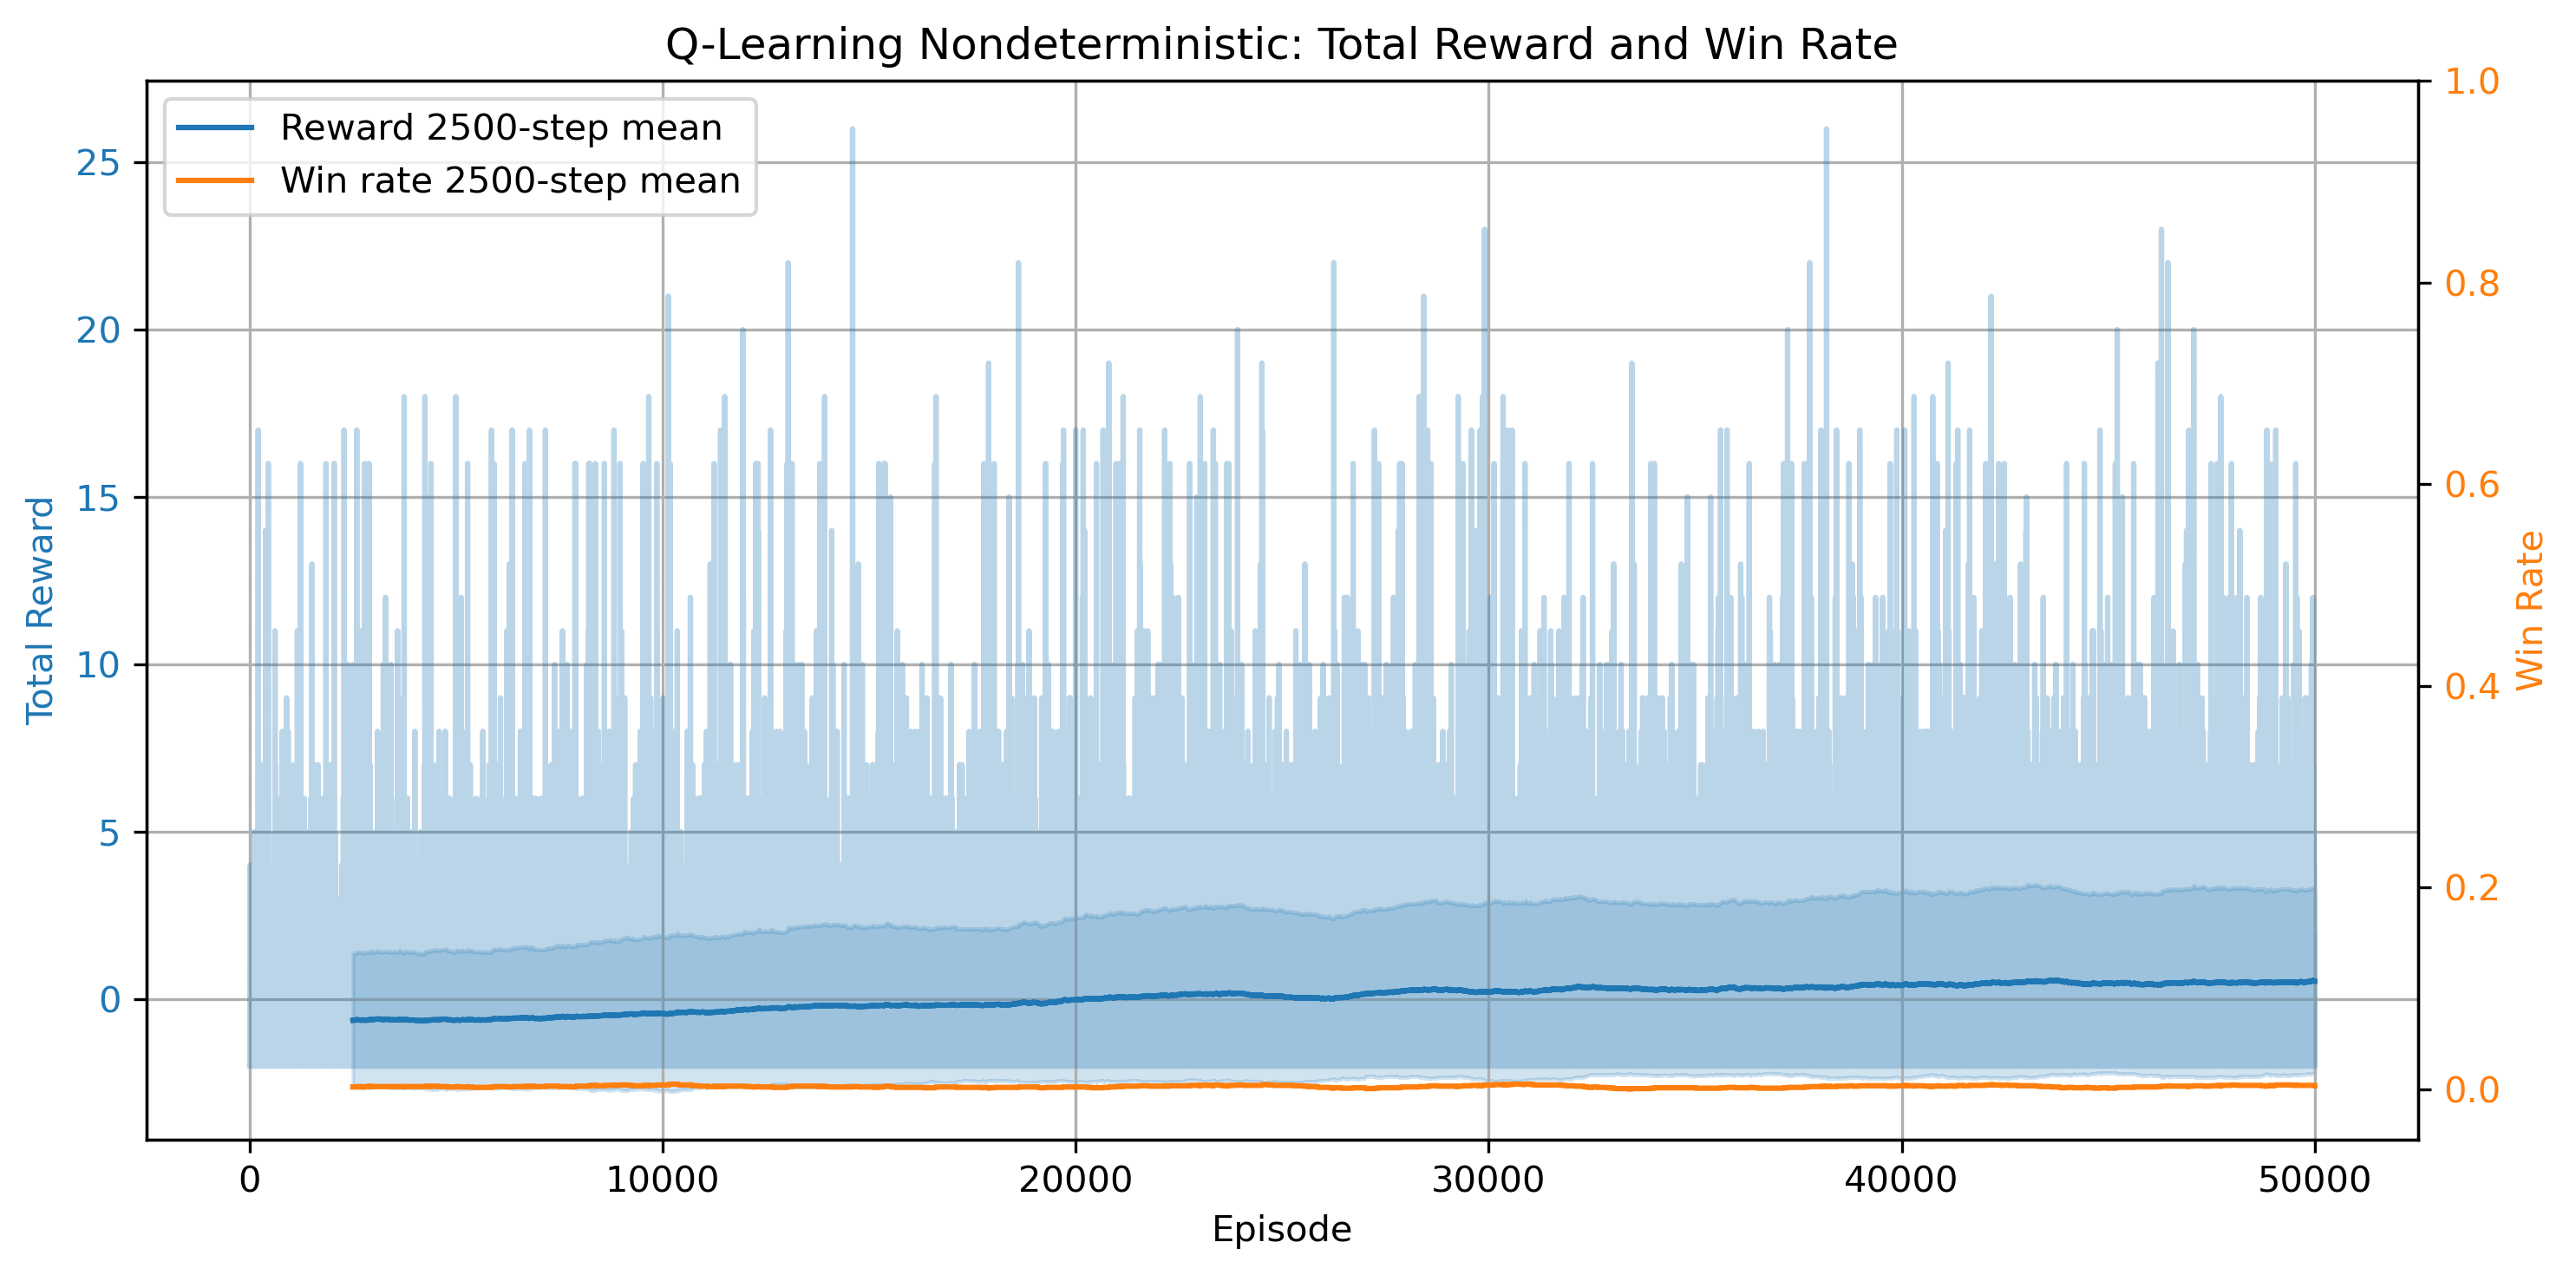

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_combined_reward_win_simple(csv_path, figsize=(10,5),
                                    save_path=None, title=None, dpi=300, show_std=False):
    """
    Plot total reward and win rate from a CSV with columns:
      'episode', 'train_reward', 'win', 'roll_mean', 'roll_std', 'roll_win'.
    Ensures numeric types for plotting.
    """
    df = pd.read_csv(csv_path)
    # Ensure numeric
    for col in ['train_reward', 'roll_mean', 'roll_std', 'roll_win']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    fig, ax1 = plt.subplots(figsize=figsize, dpi=dpi)
    
    if show_std:
        ax1.plot(df['episode'], df['train_reward'],
                 alpha=0.3, label='Raw Reward', color='tab:blue')
        ax1.fill_between(df['episode'],
                         df['roll_mean'] - df['roll_std'],
                         df['roll_mean'] + df['roll_std'],
                         alpha=0.2, color='tab:blue')
    
    ln1 = ax1.plot(df['episode'], df['roll_mean'],
                   label='Reward 2500-step mean', color='tab:blue')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    ax2 = ax1.twinx()
    ln2 = ax2.plot(df['episode'], df['roll_win'],
                   label='Win rate 2500-step mean', color='tab:orange')
    ax2.set_ylabel('Win Rate', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylim(-0.05,1)
    
    if title:
        ax1.set_title(title)
    ax1.grid(True)
    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels, loc='best')
    
    fig.tight_layout()
    save_path = title.replace(' ', '_').lower() + '.png'
    if save_path:
        fig.savefig(save_path)
    plt.show()

# Example usage
plot_combined_reward_win_simple(
    csv_path='results/NonDet/Q_learning/qlearning_nonDeterministic_results.csv',
    figsize=(10,5),
    save_path='combined_reward_winrate.png',
    title='Q-Learning Nondeterministic: Total Reward and Win Rate',
    show_std=True
)


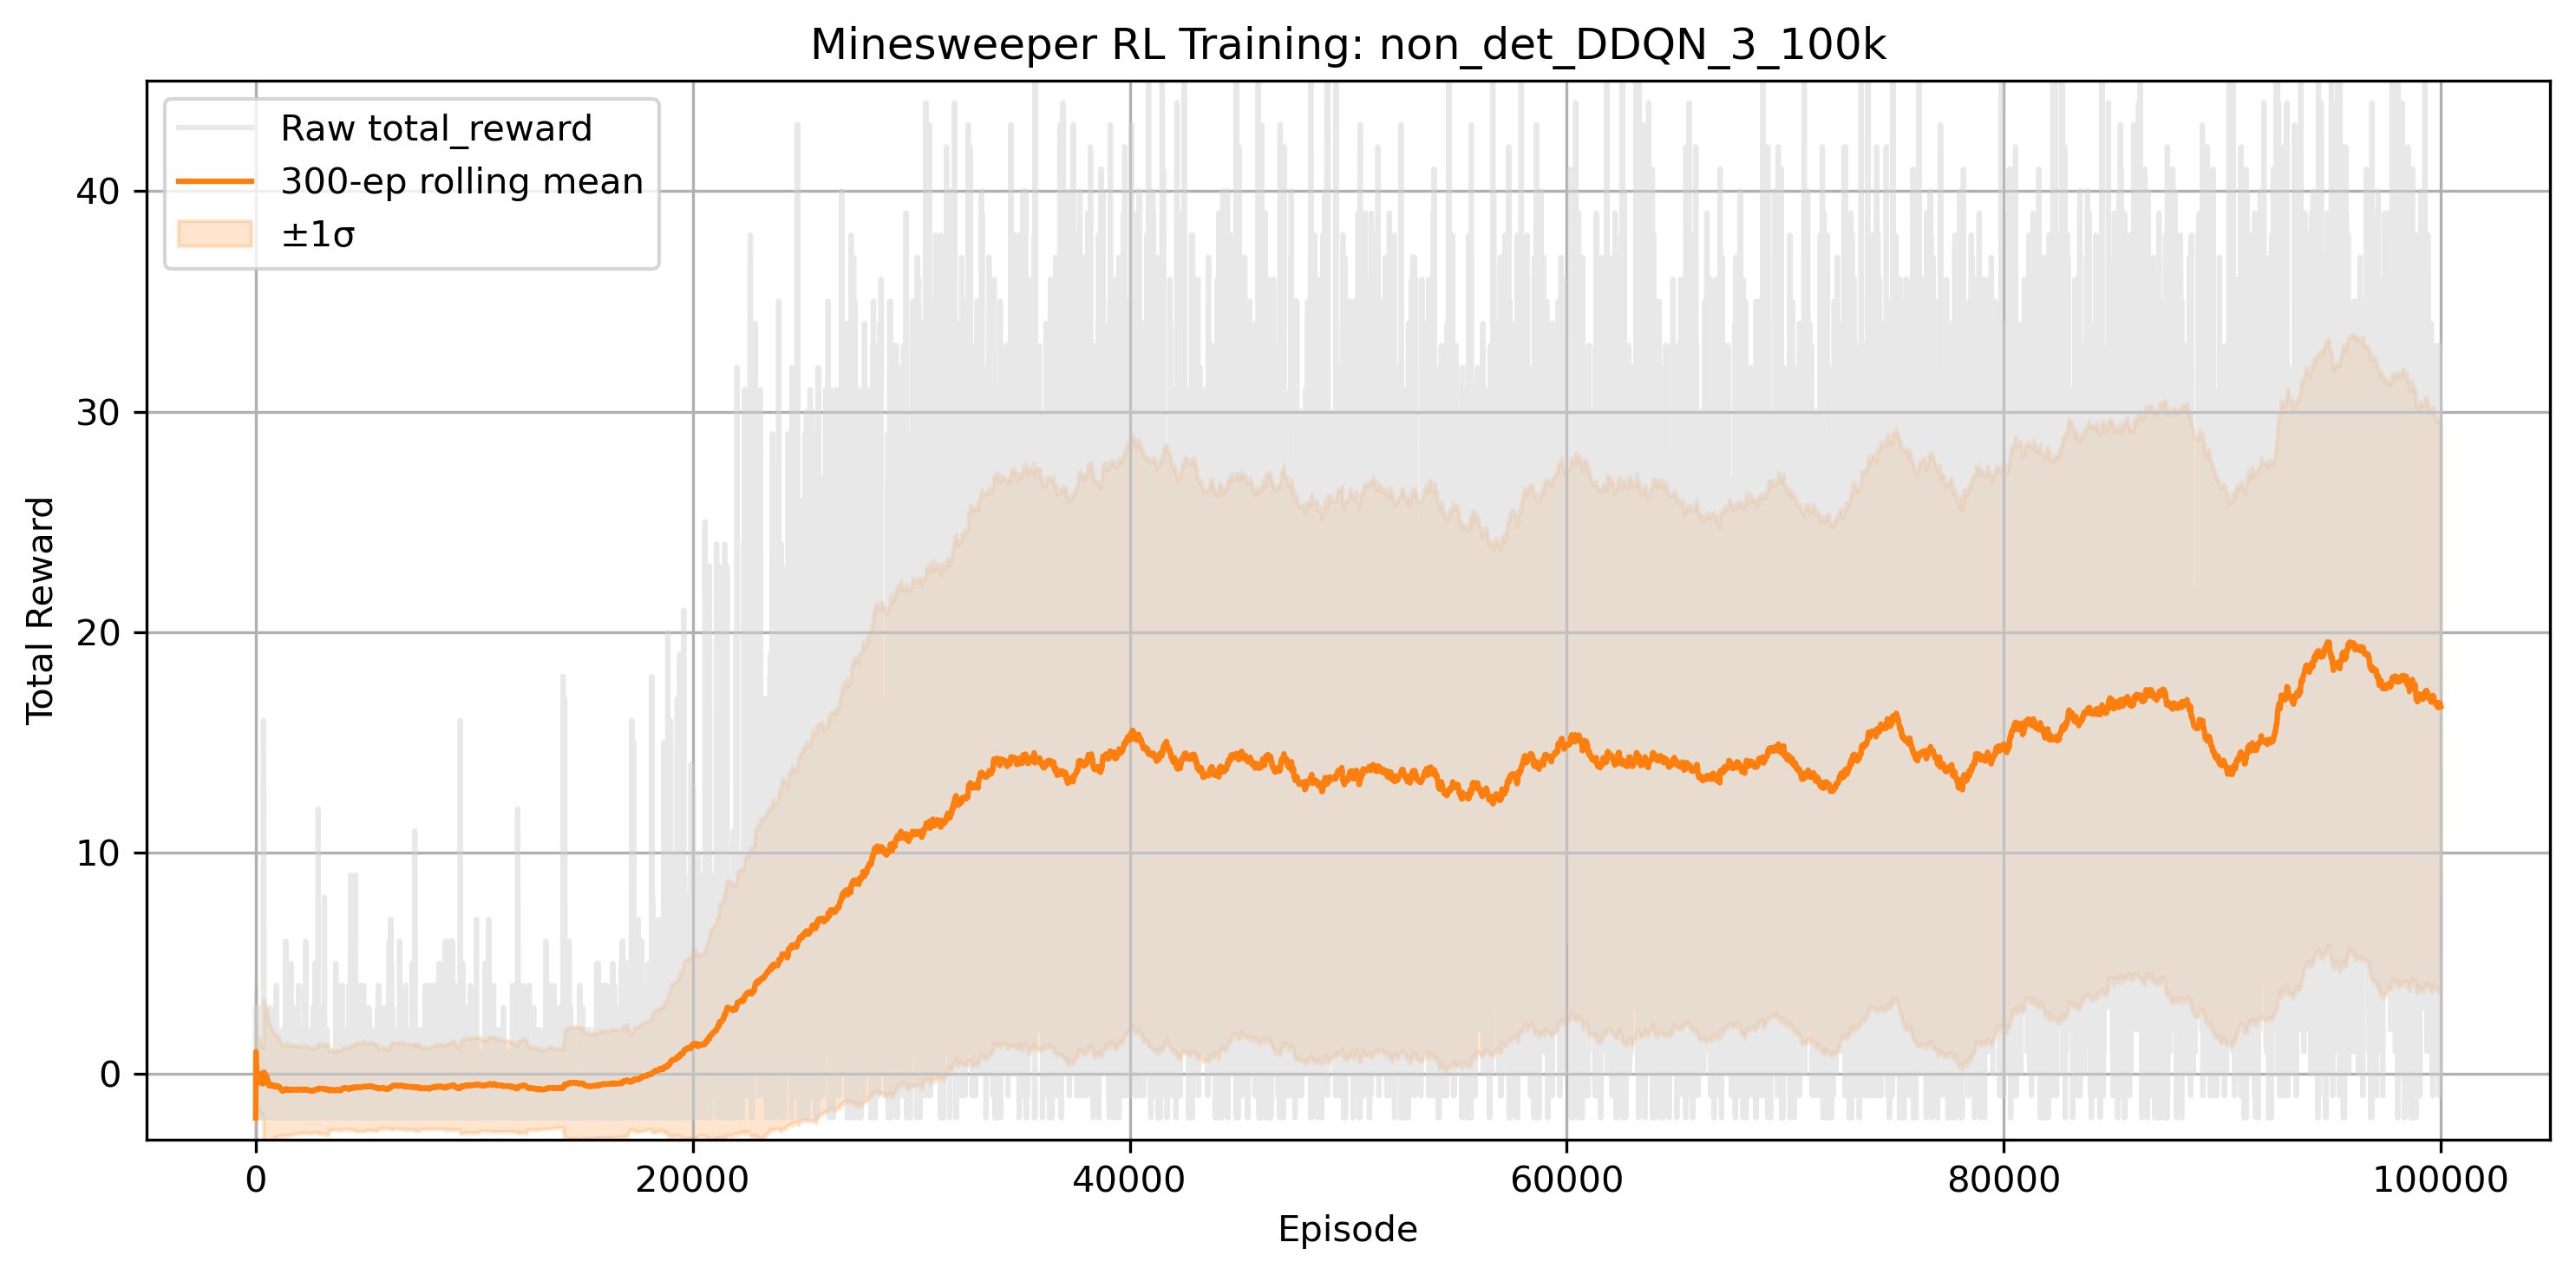

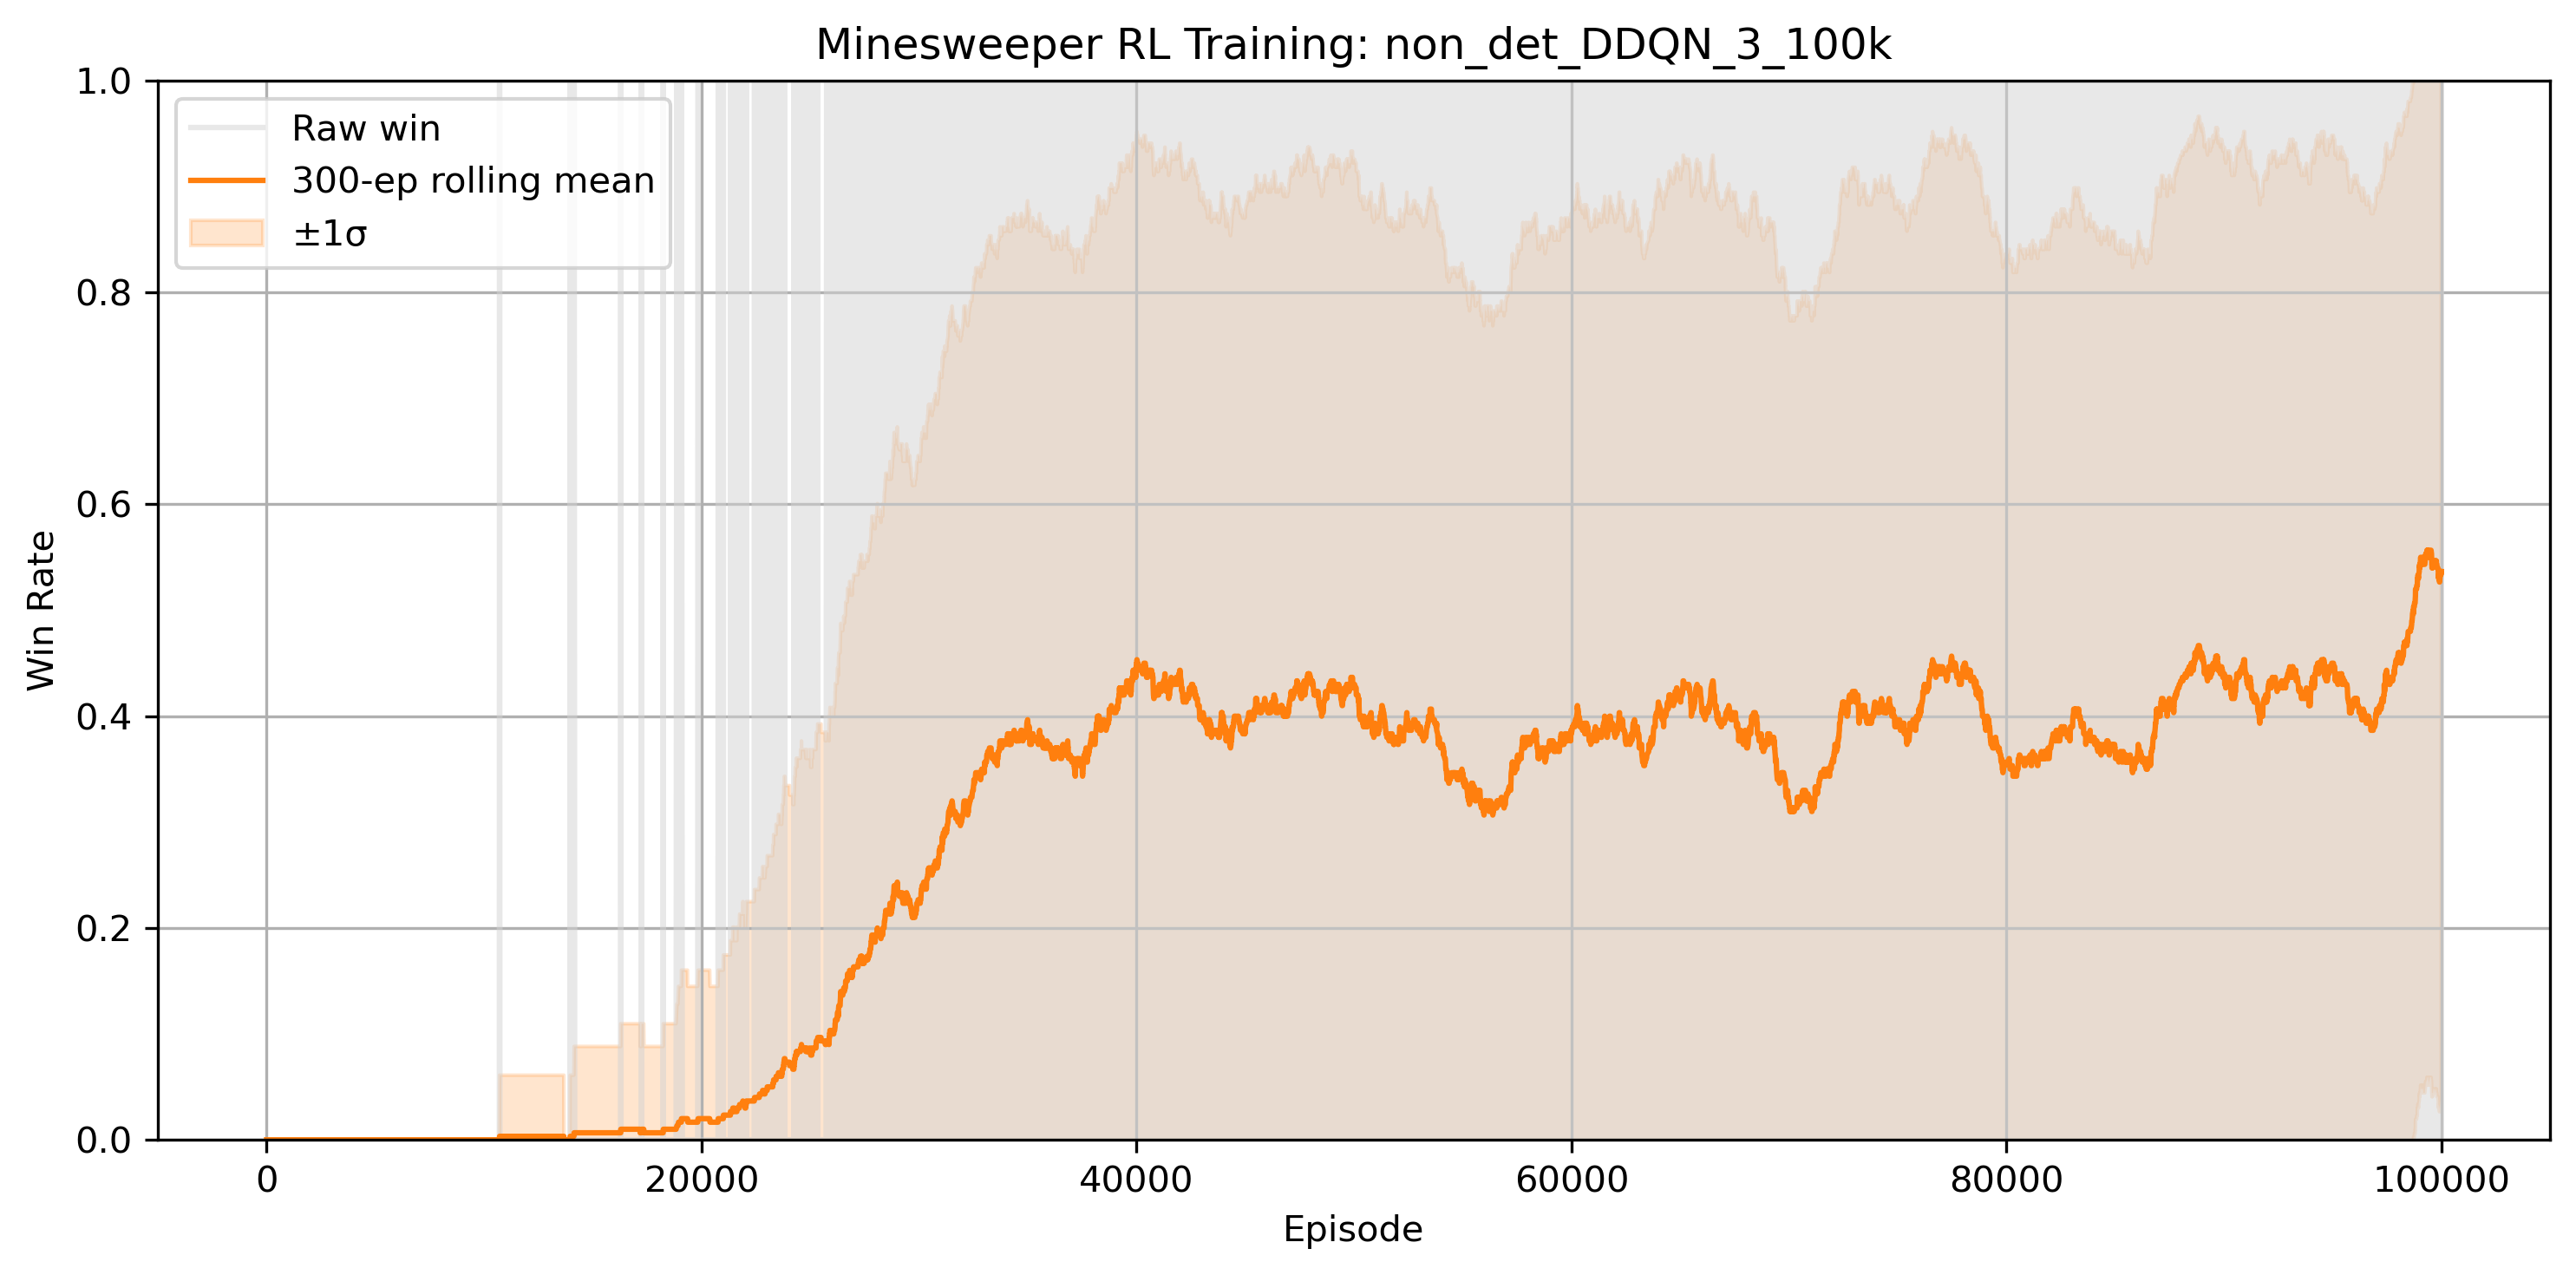

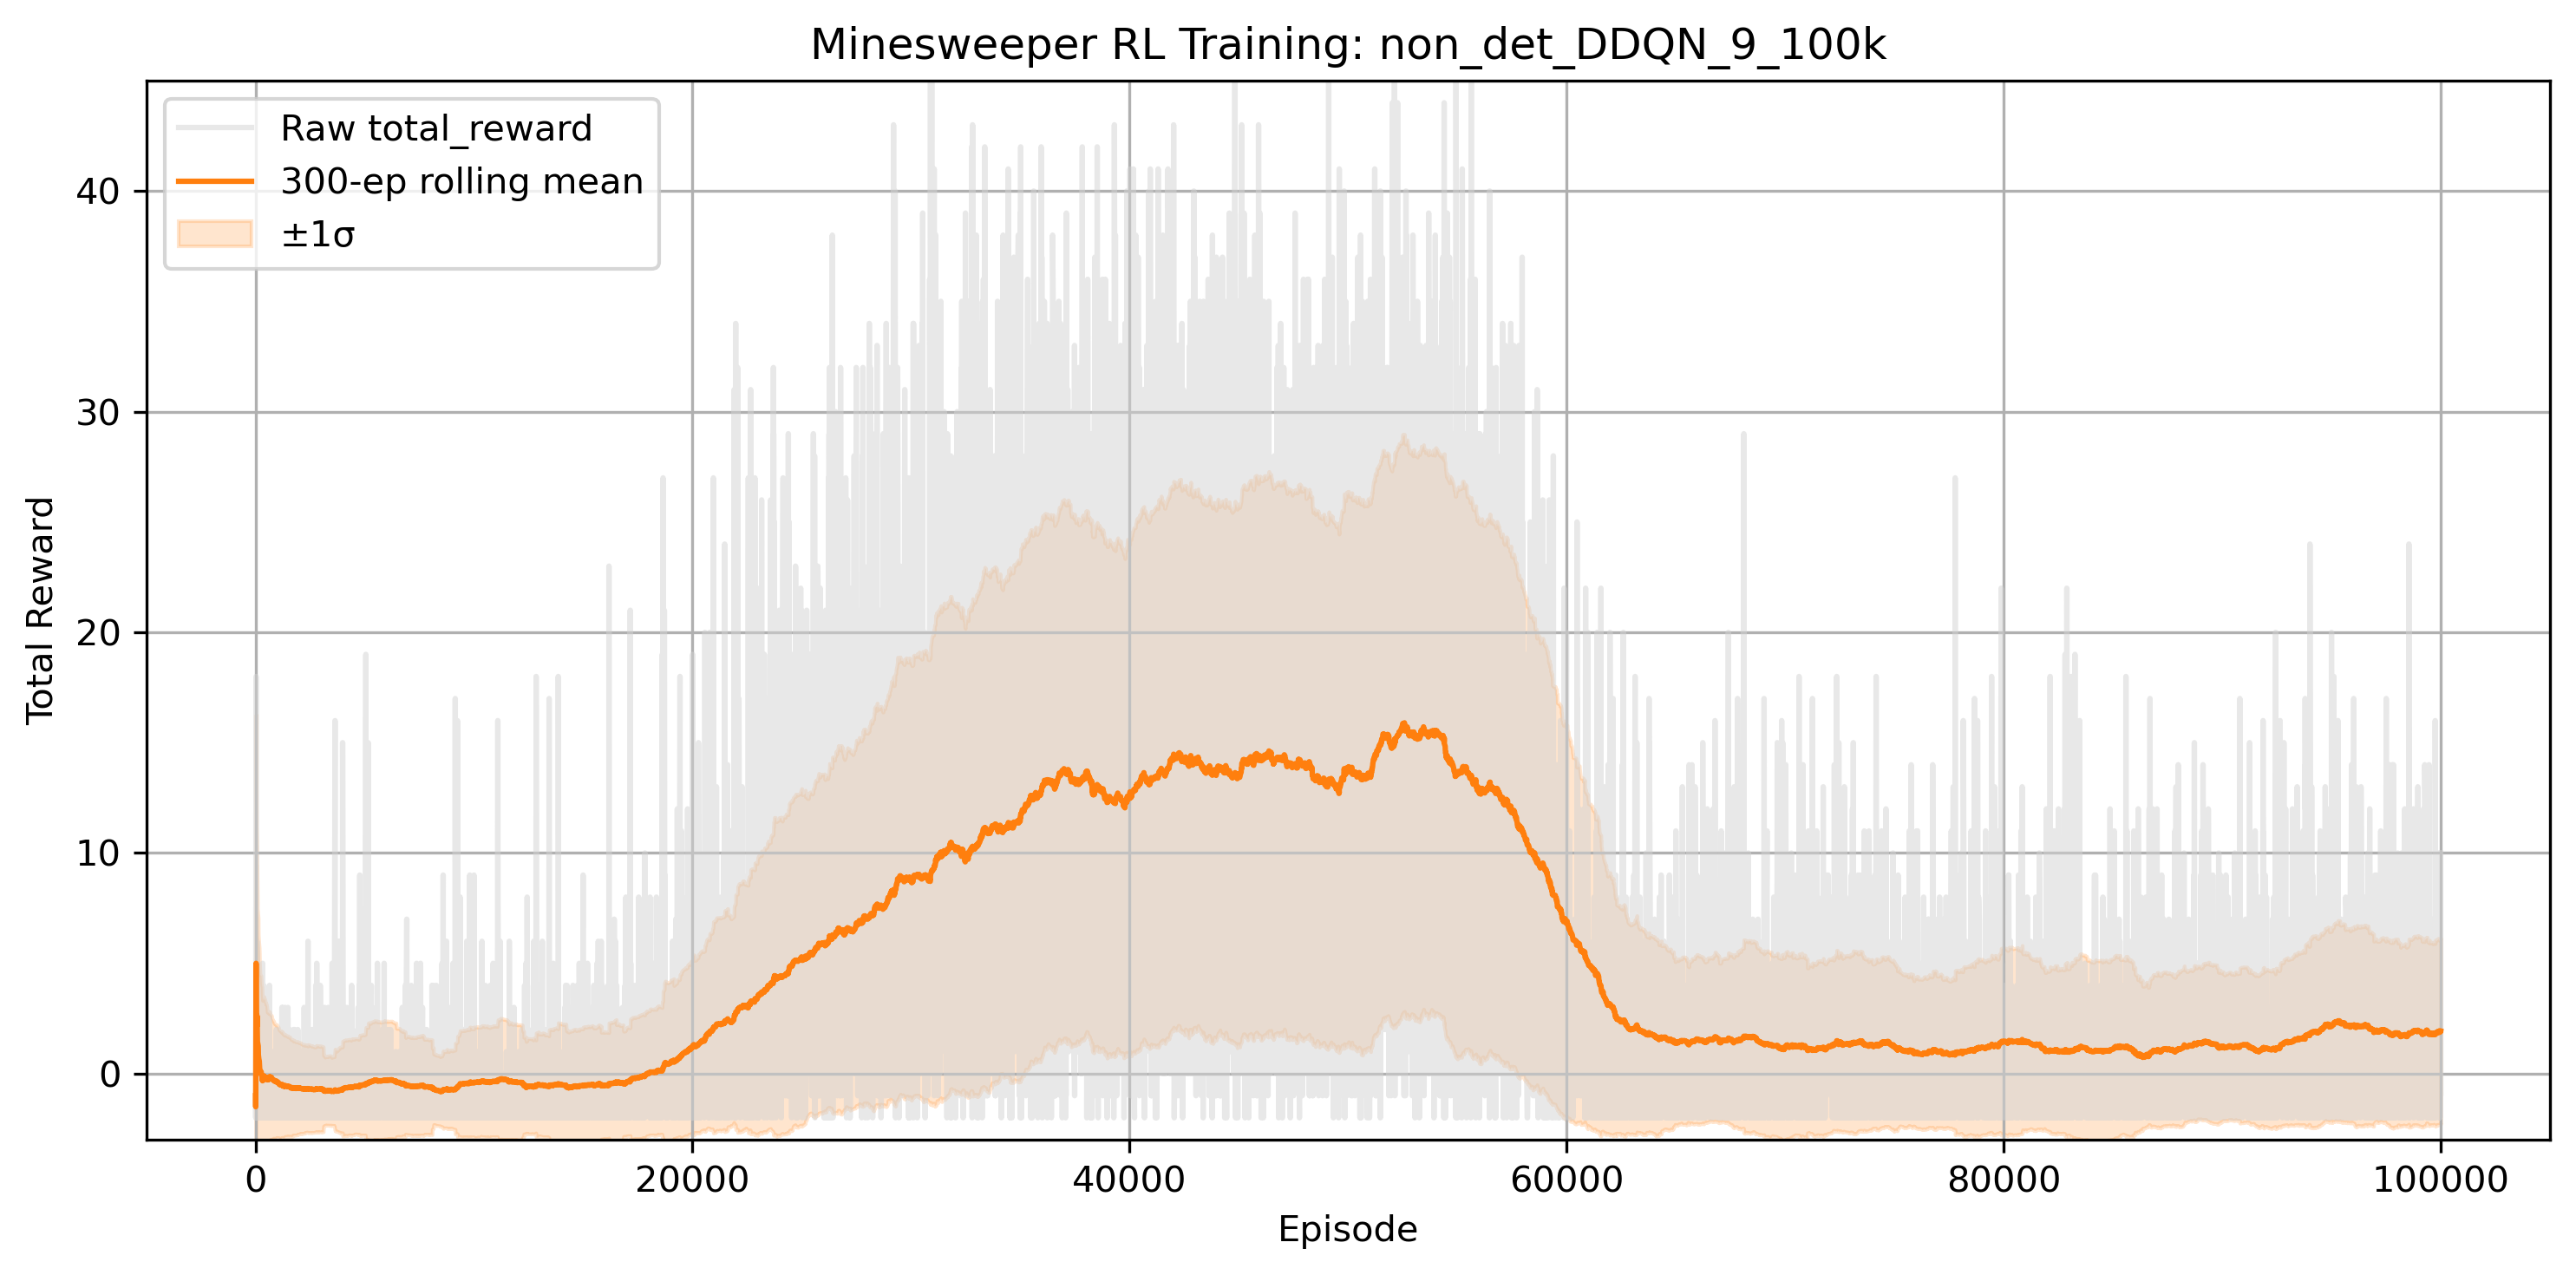

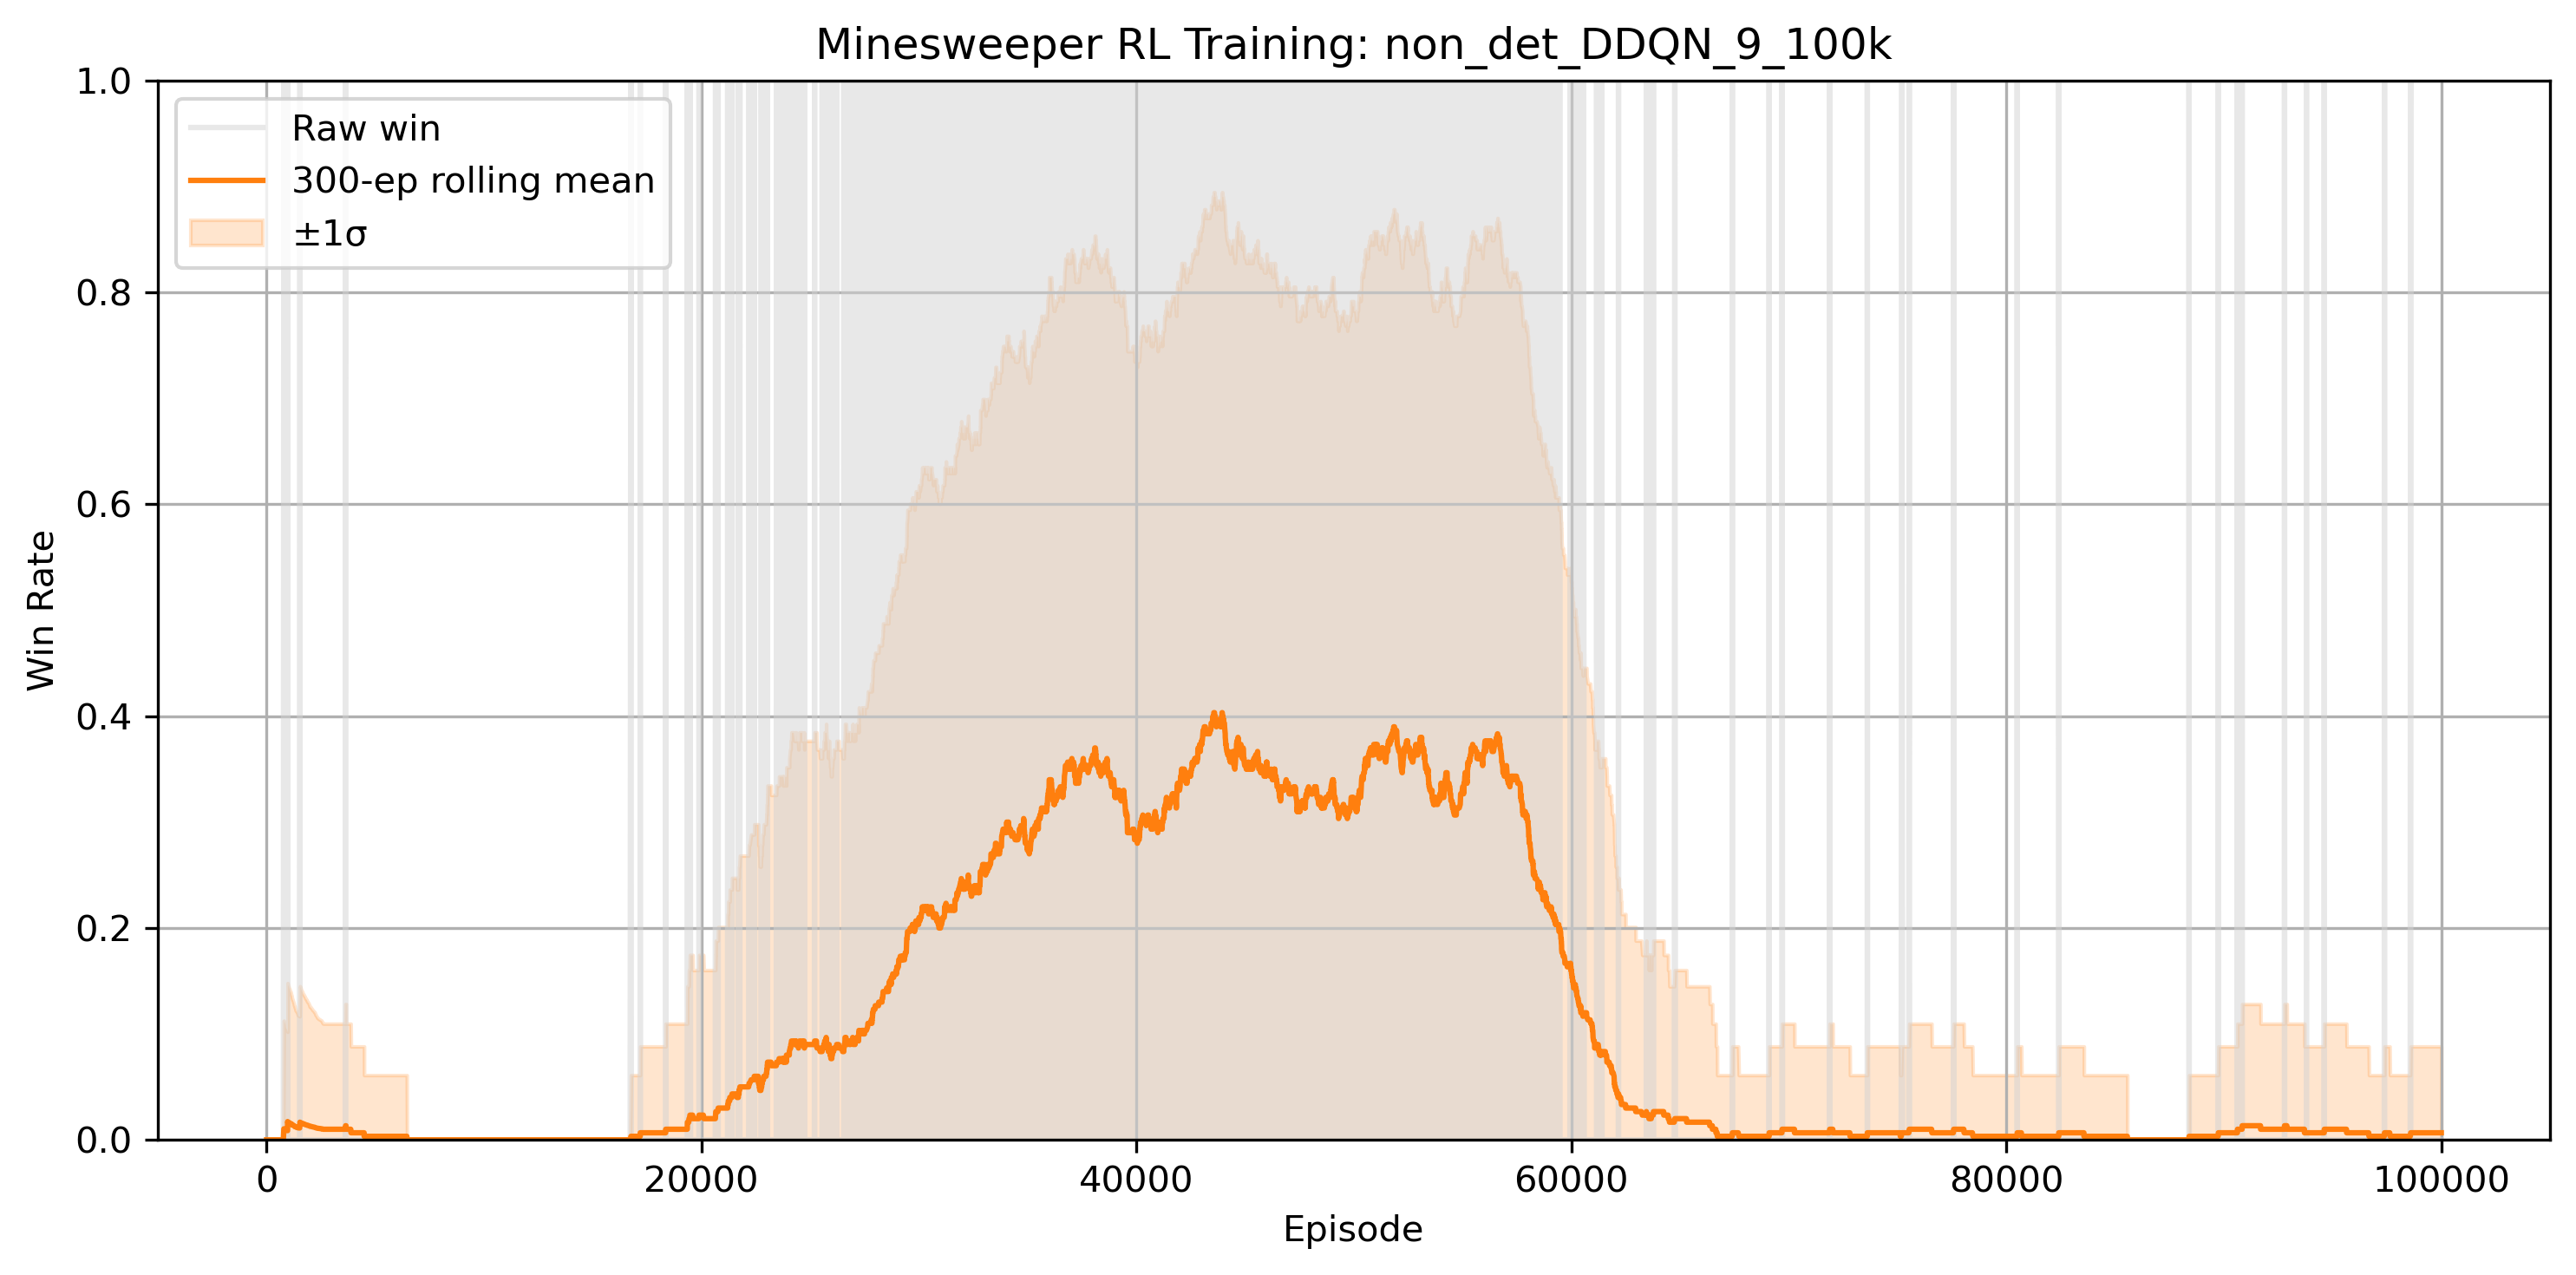

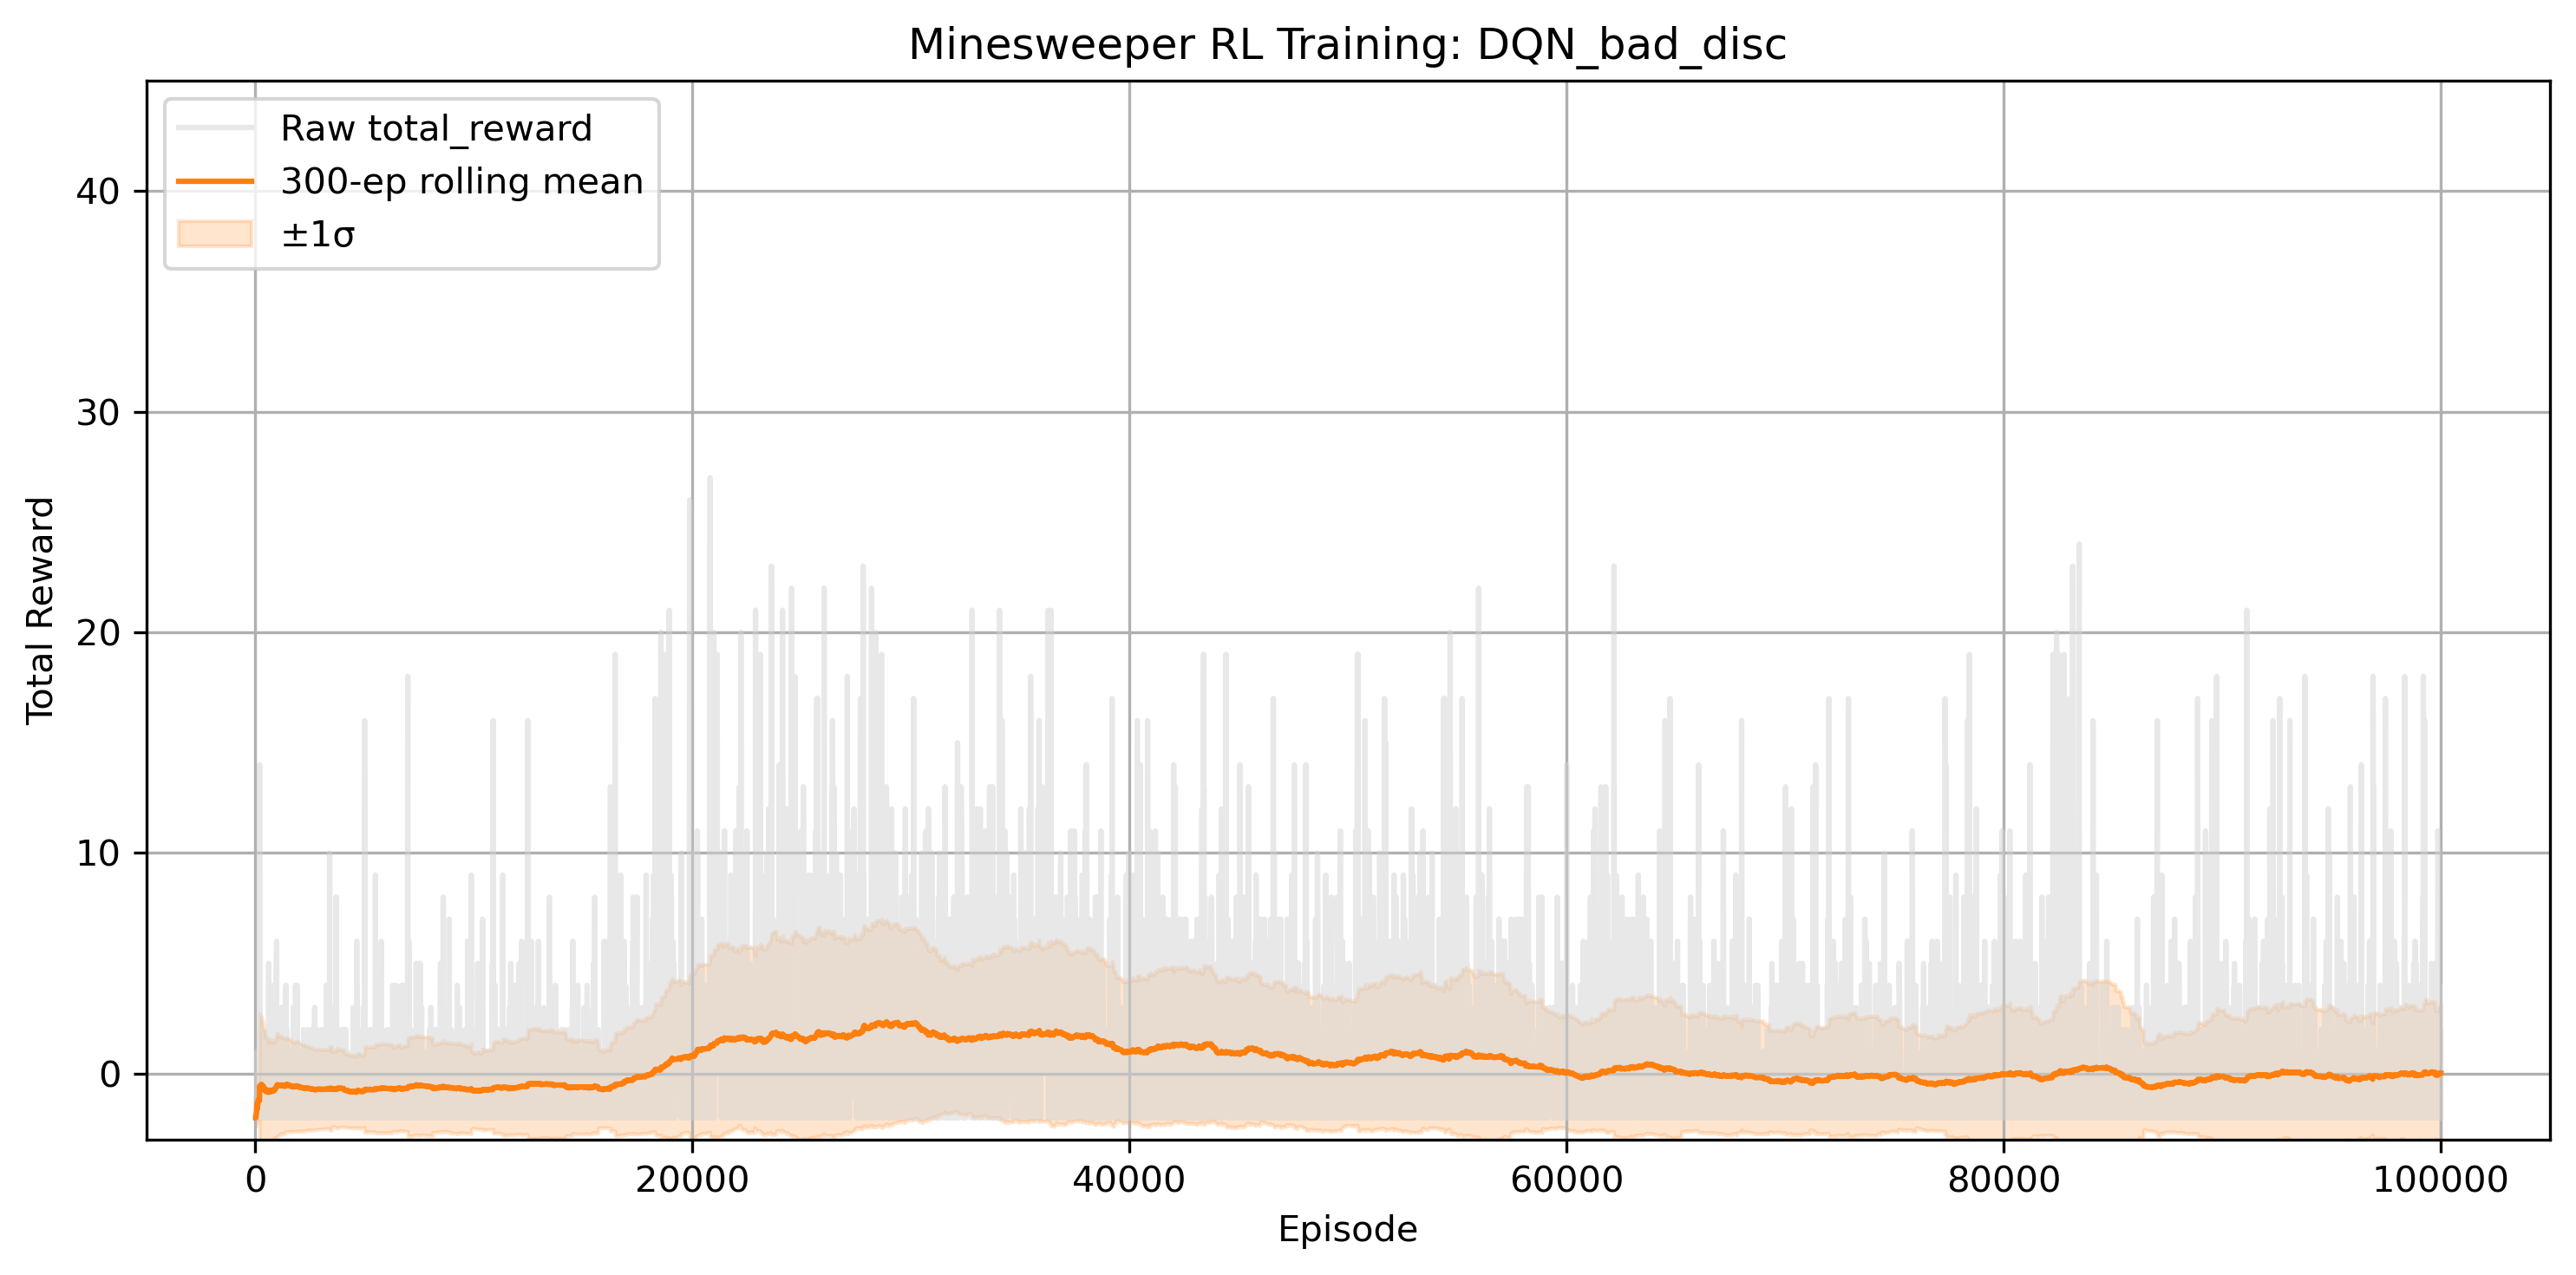

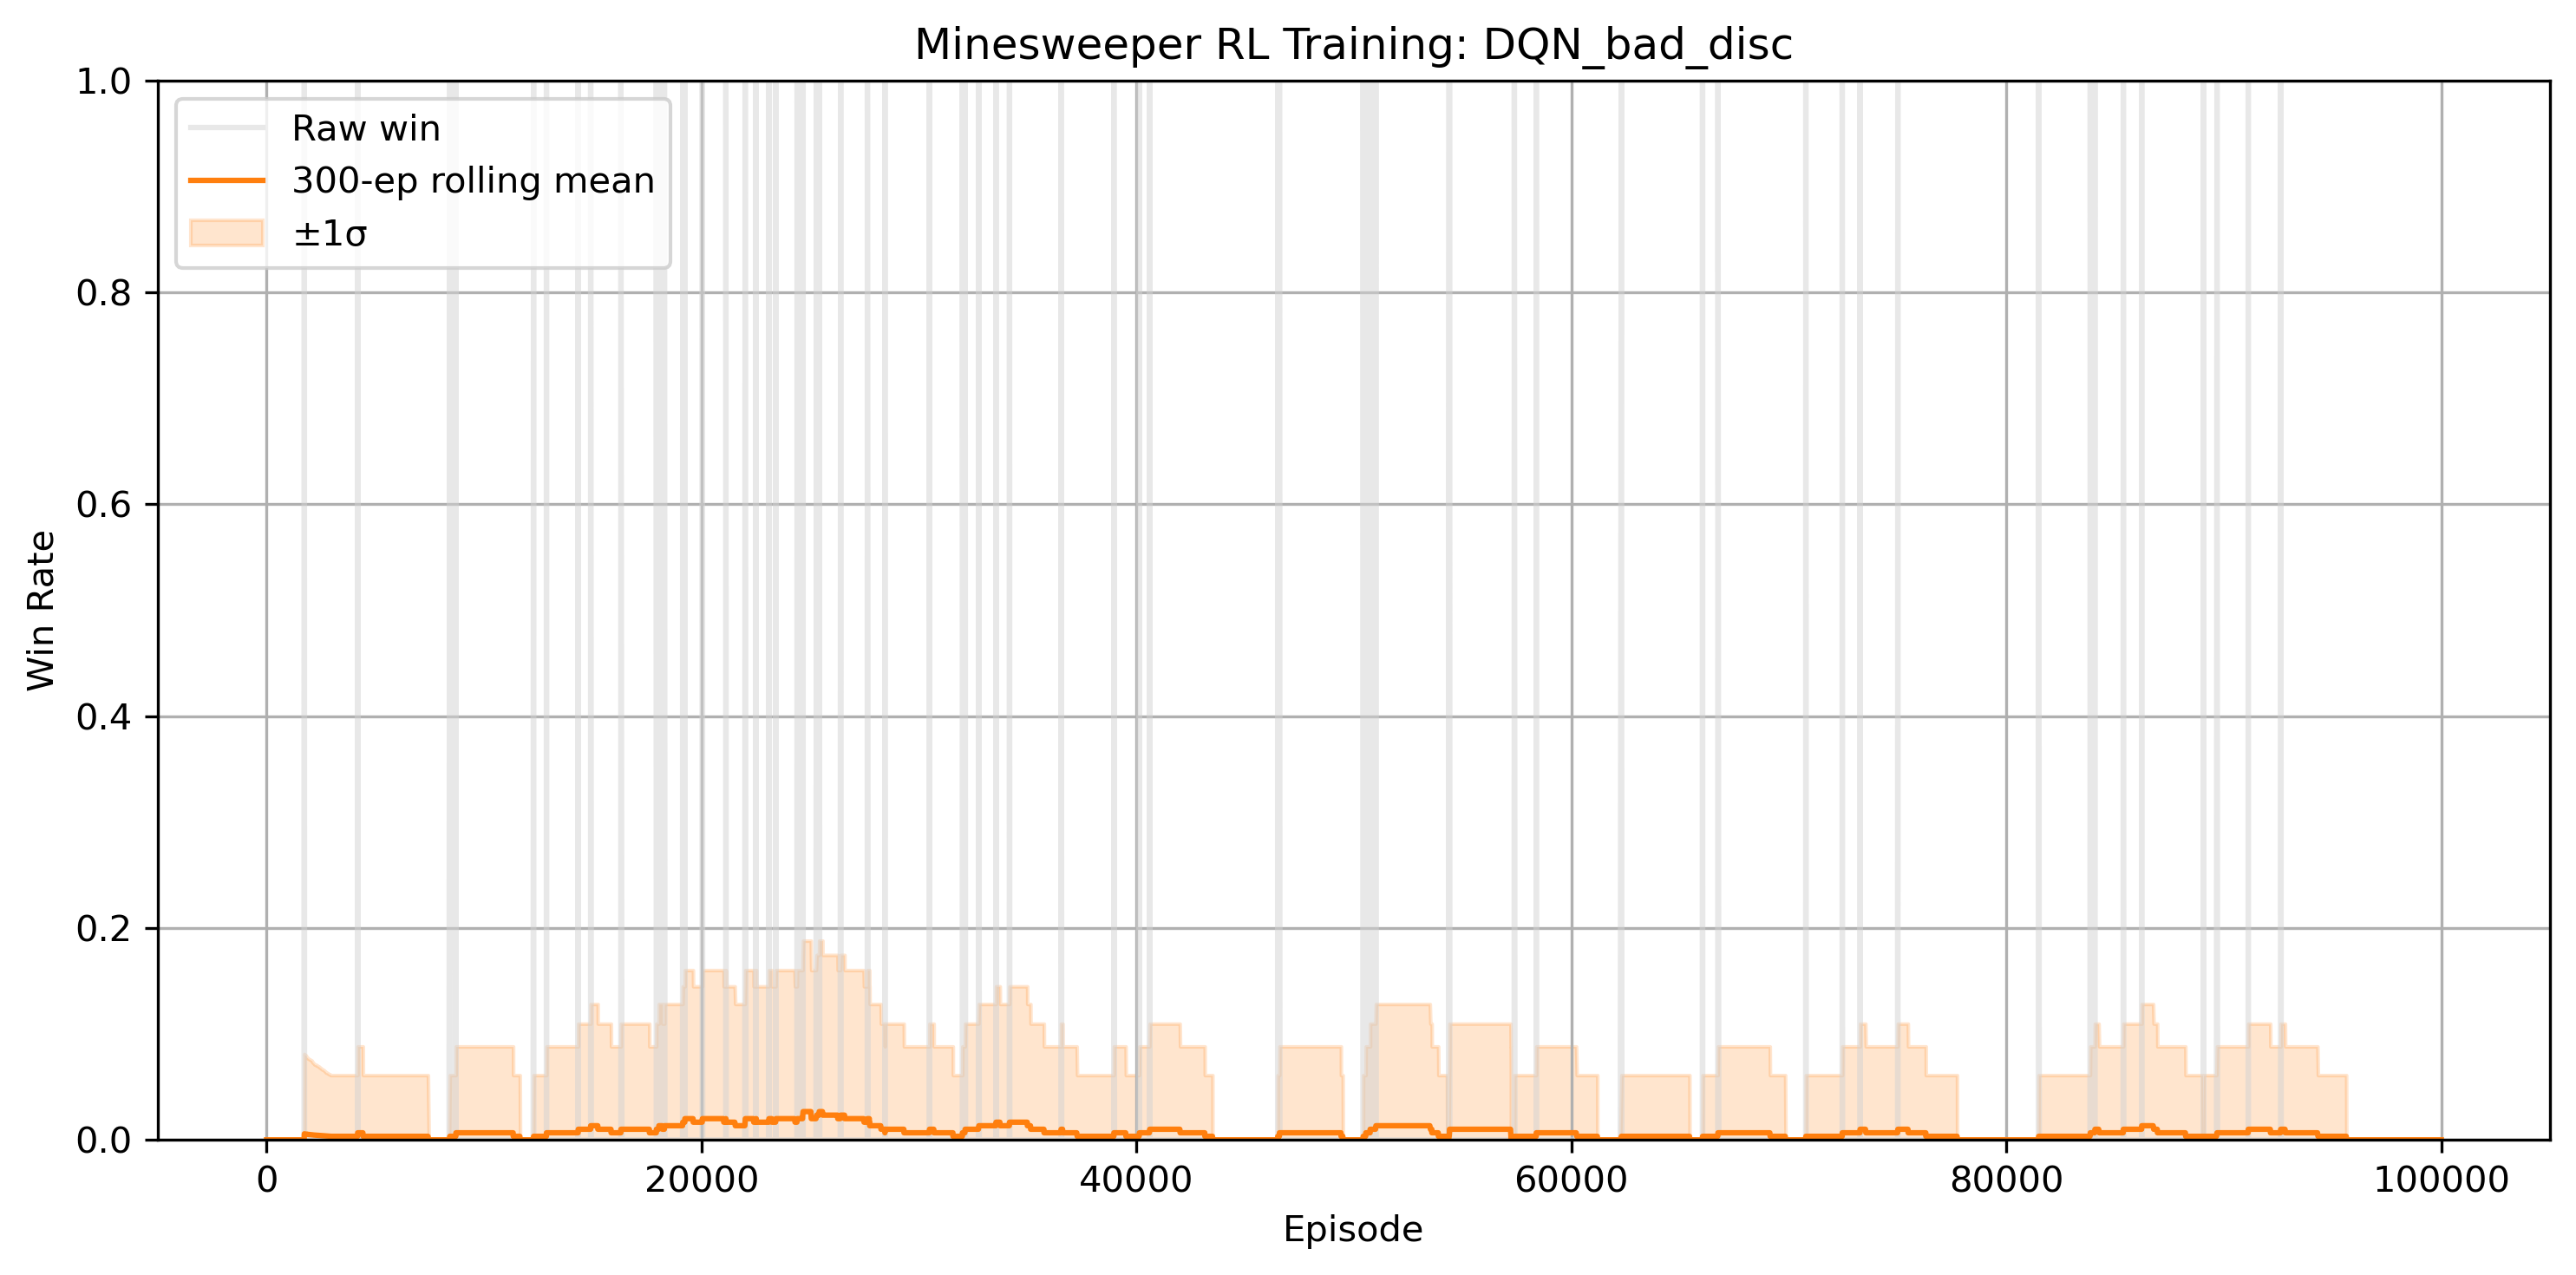

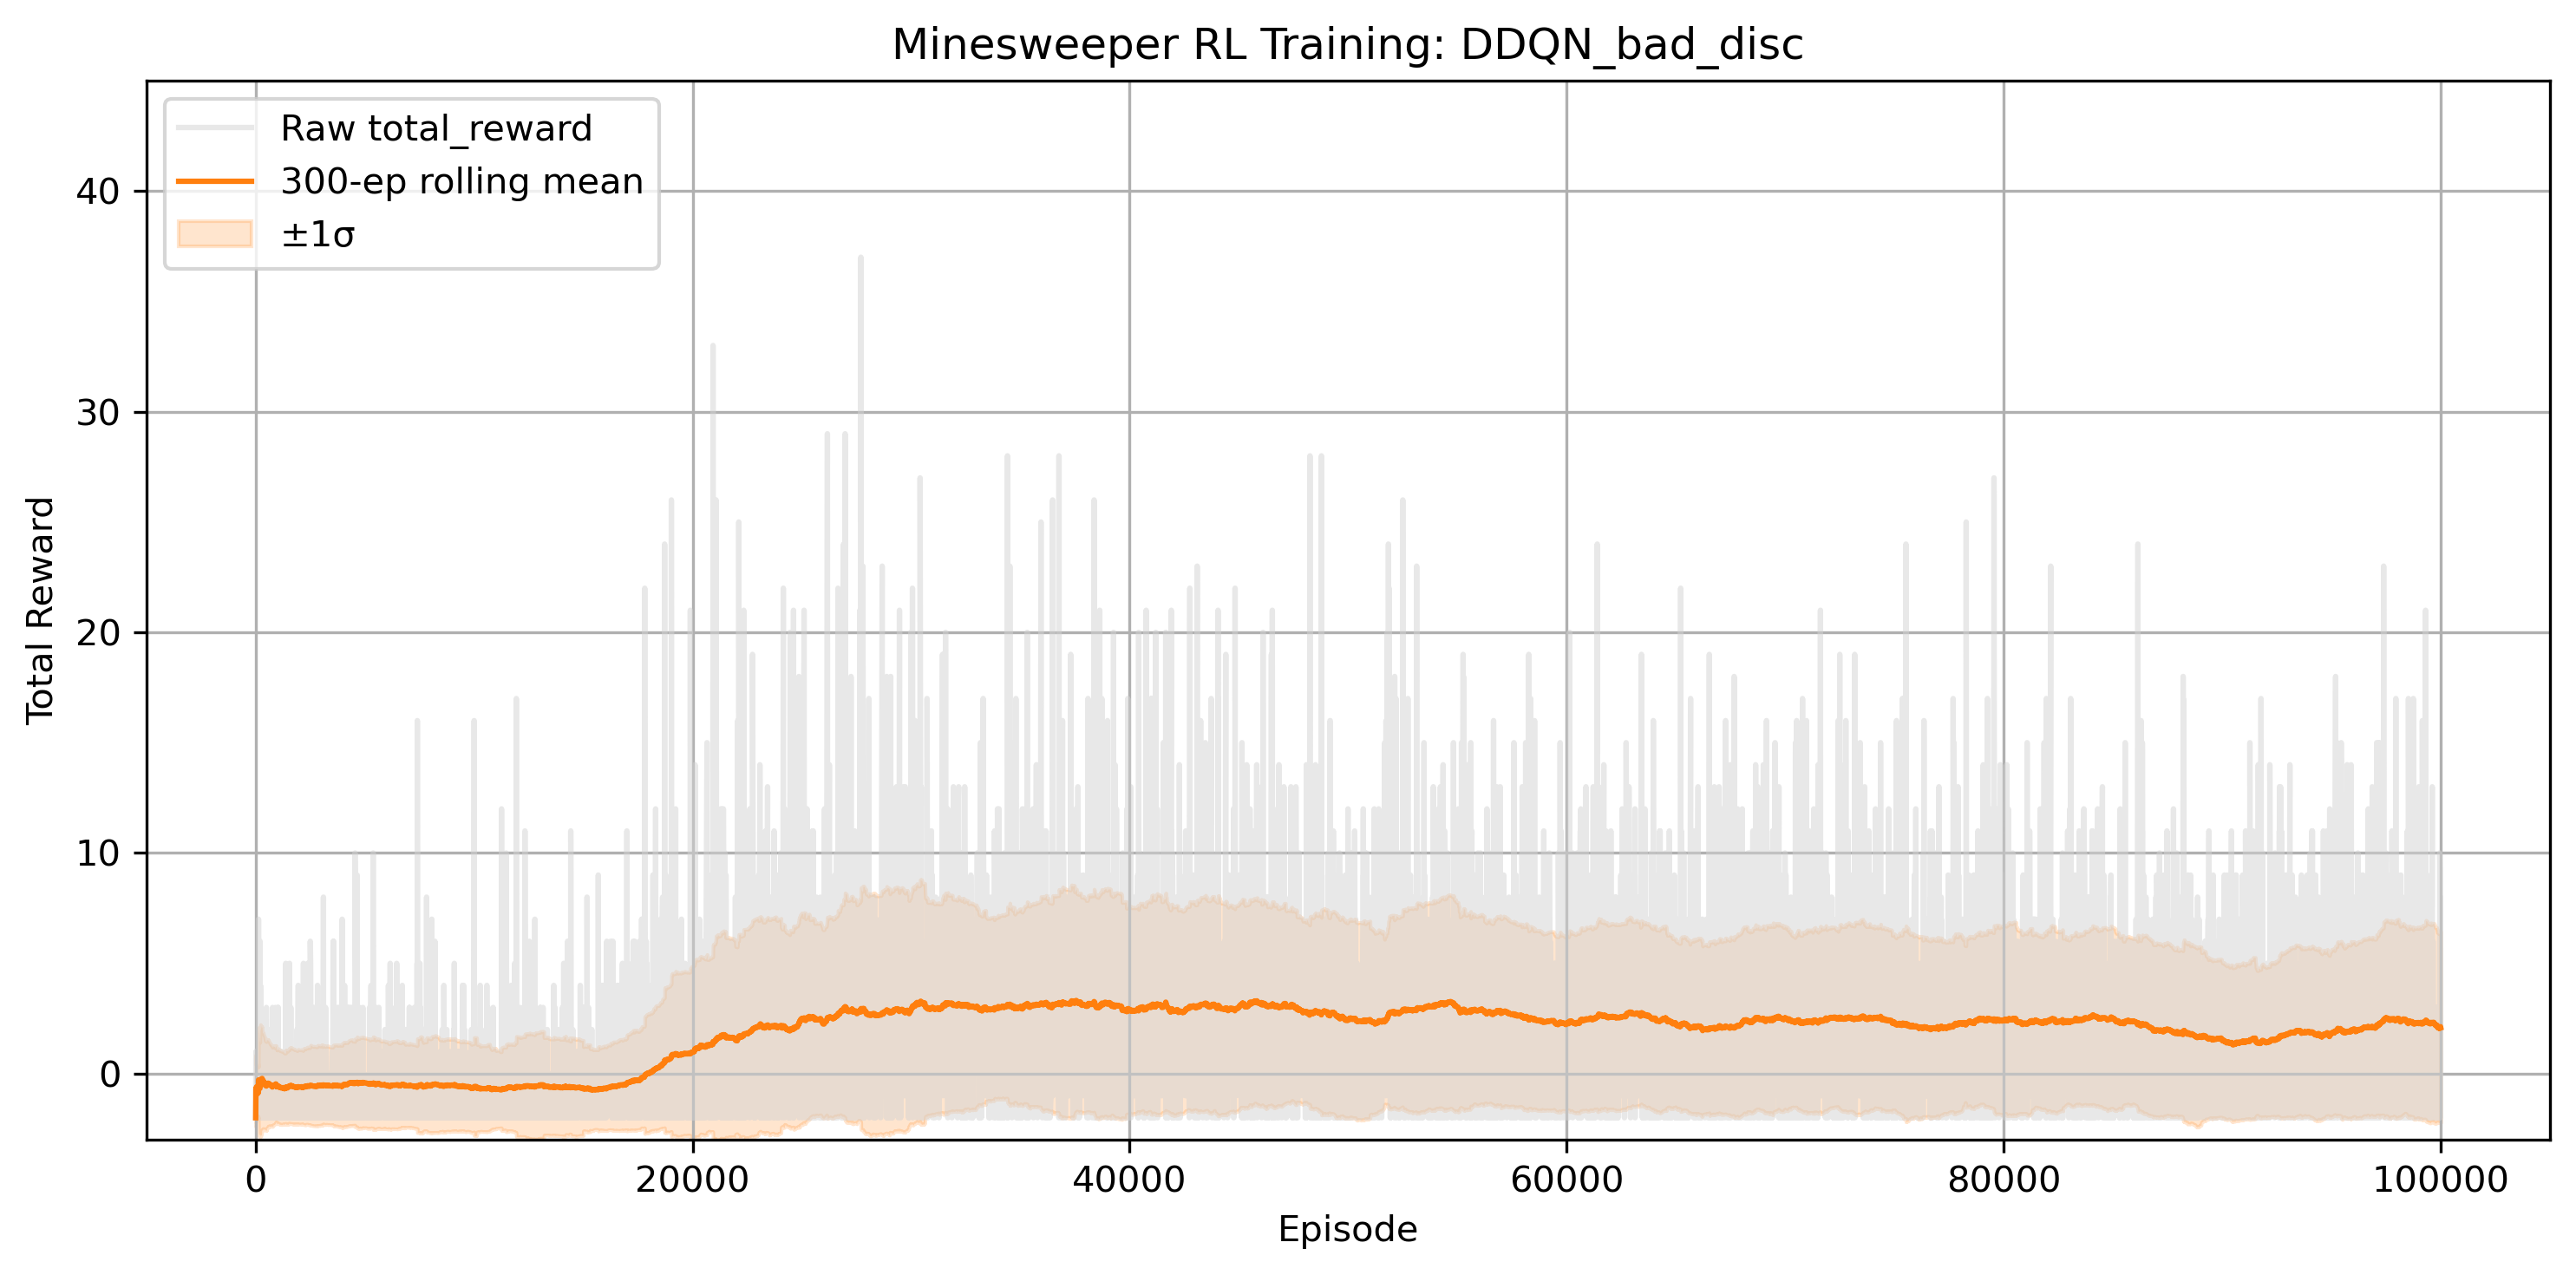

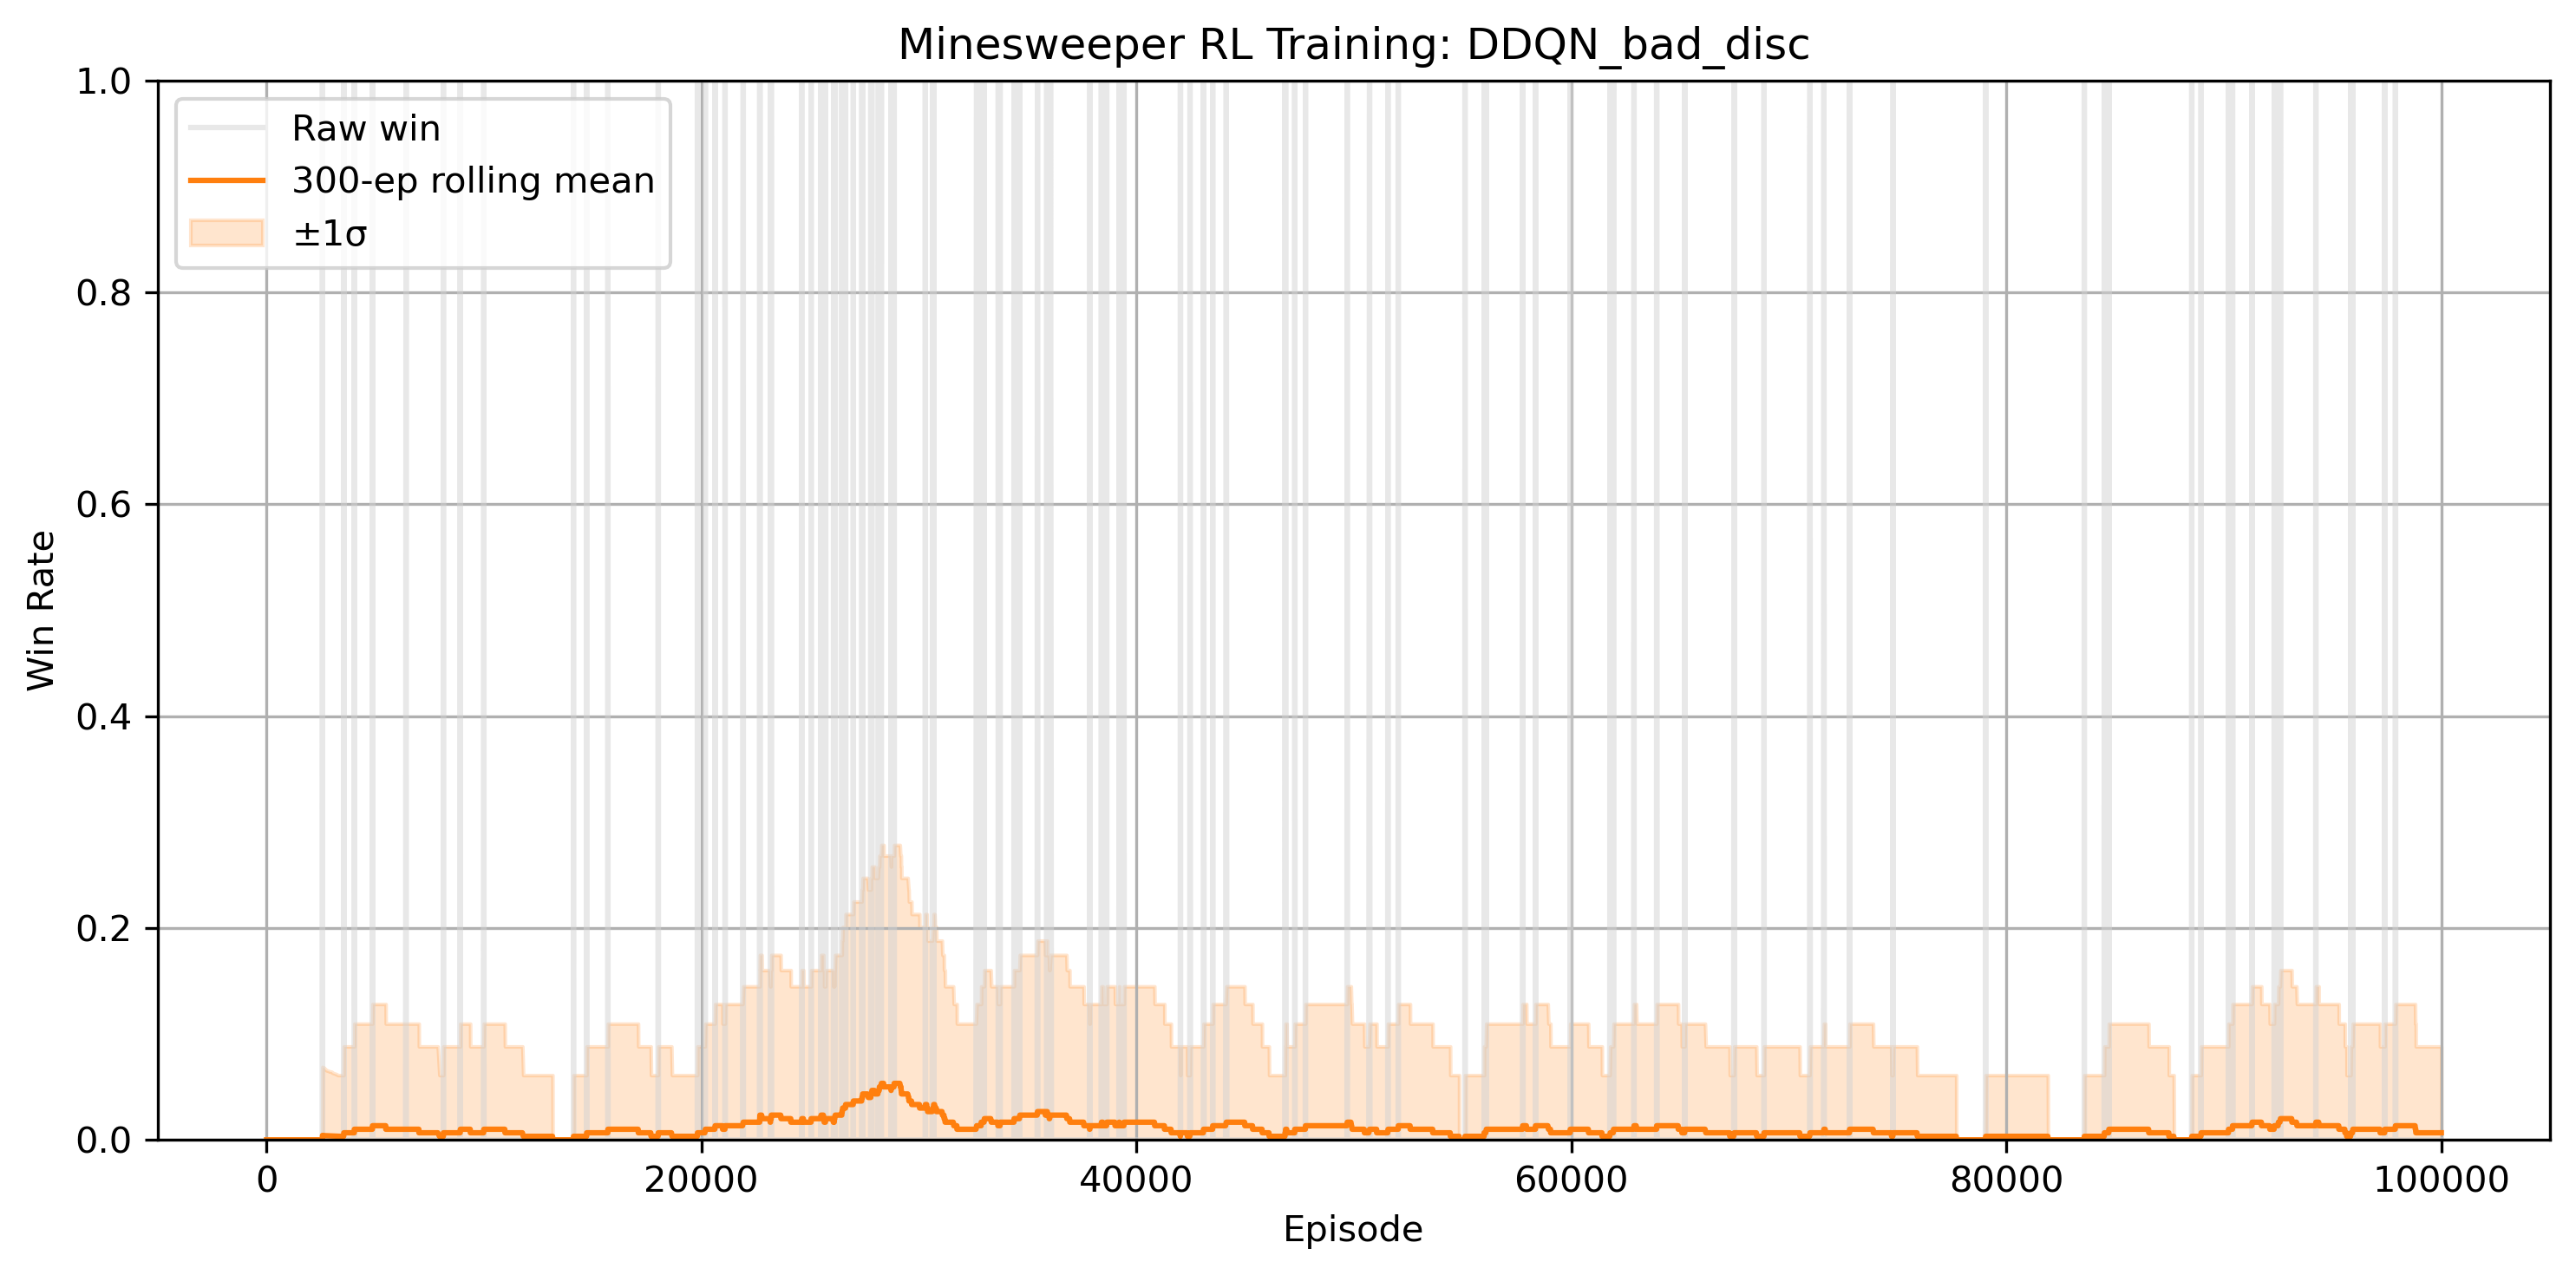

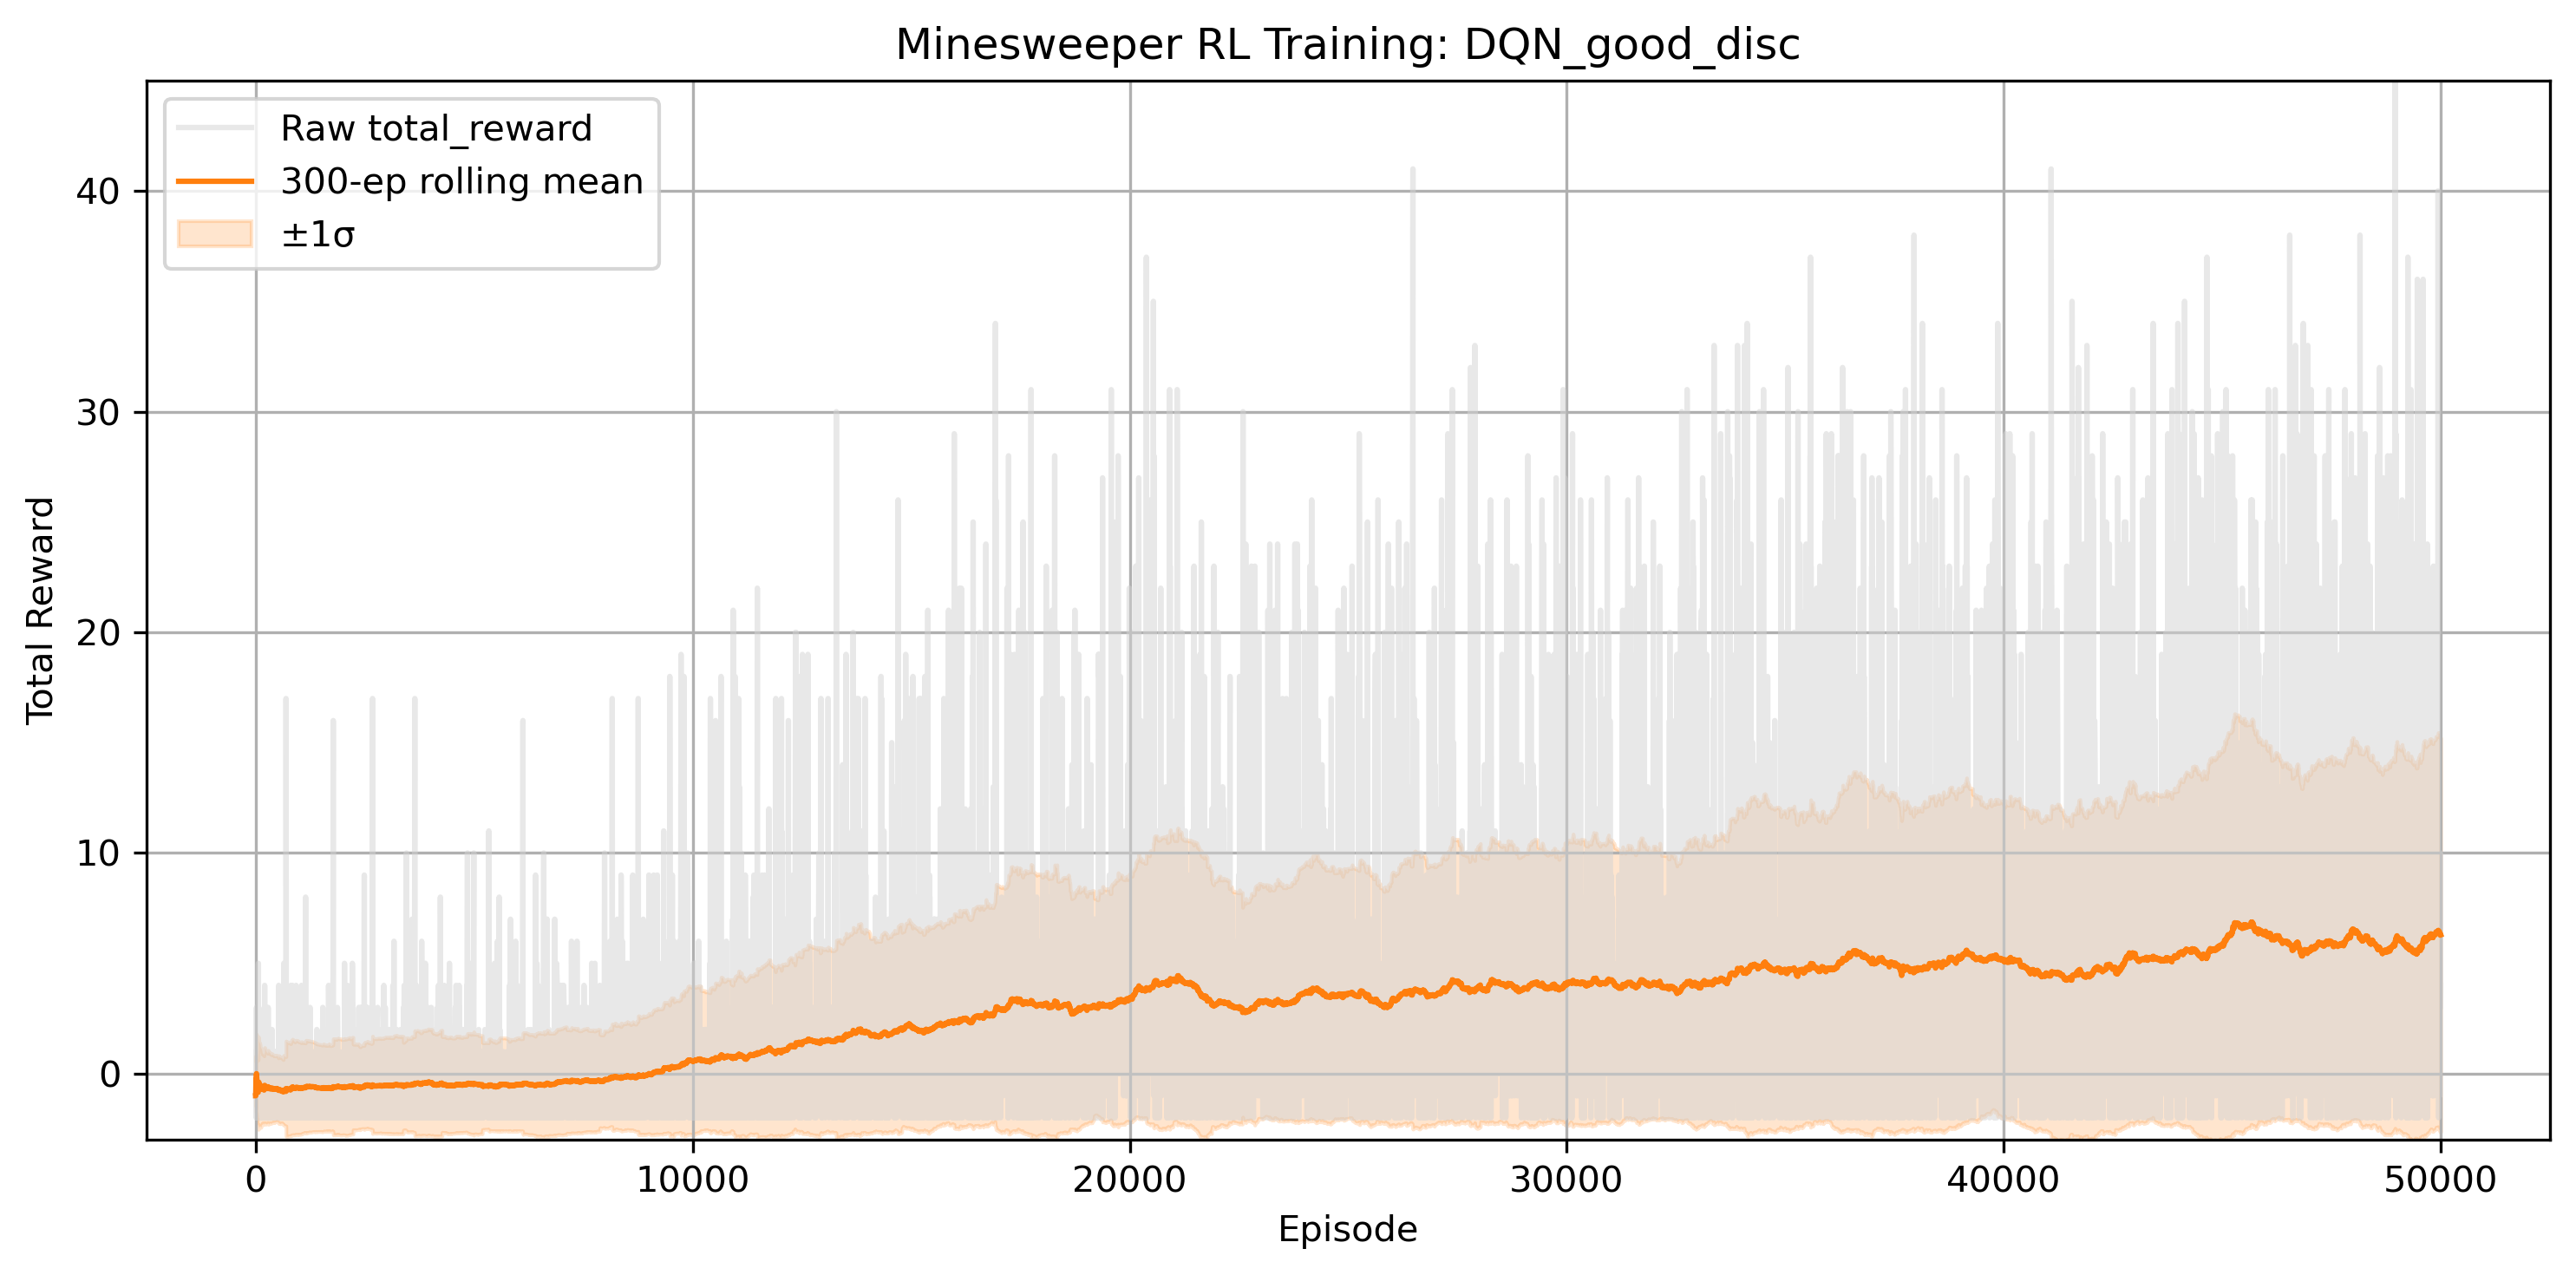

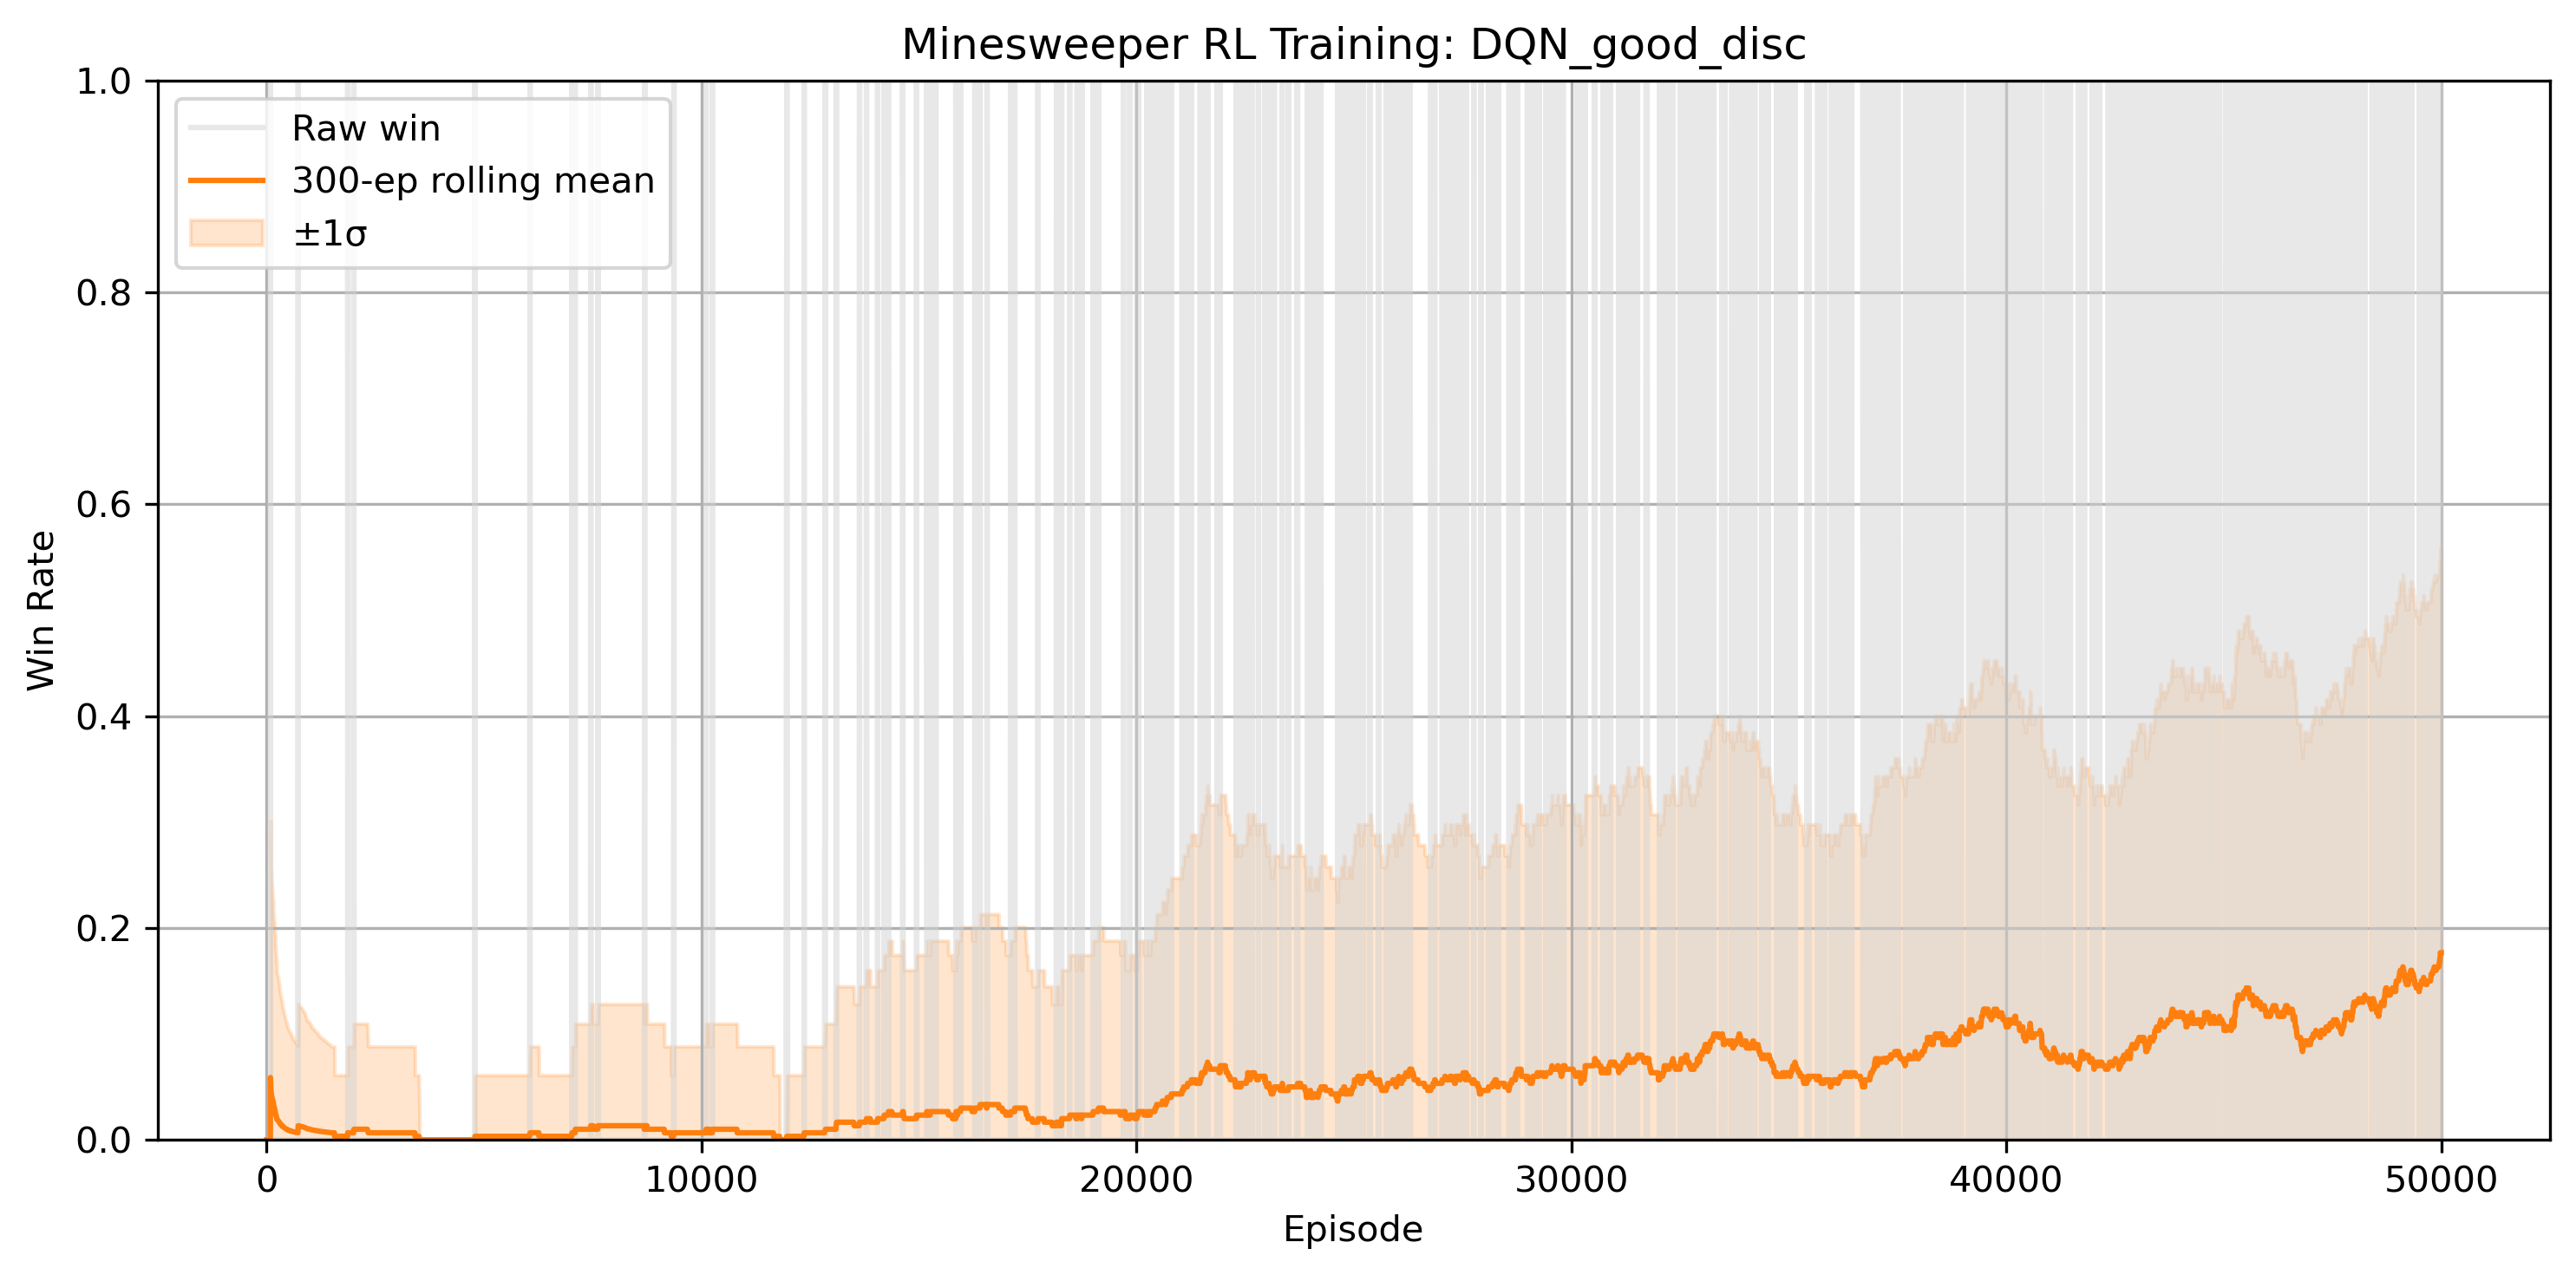

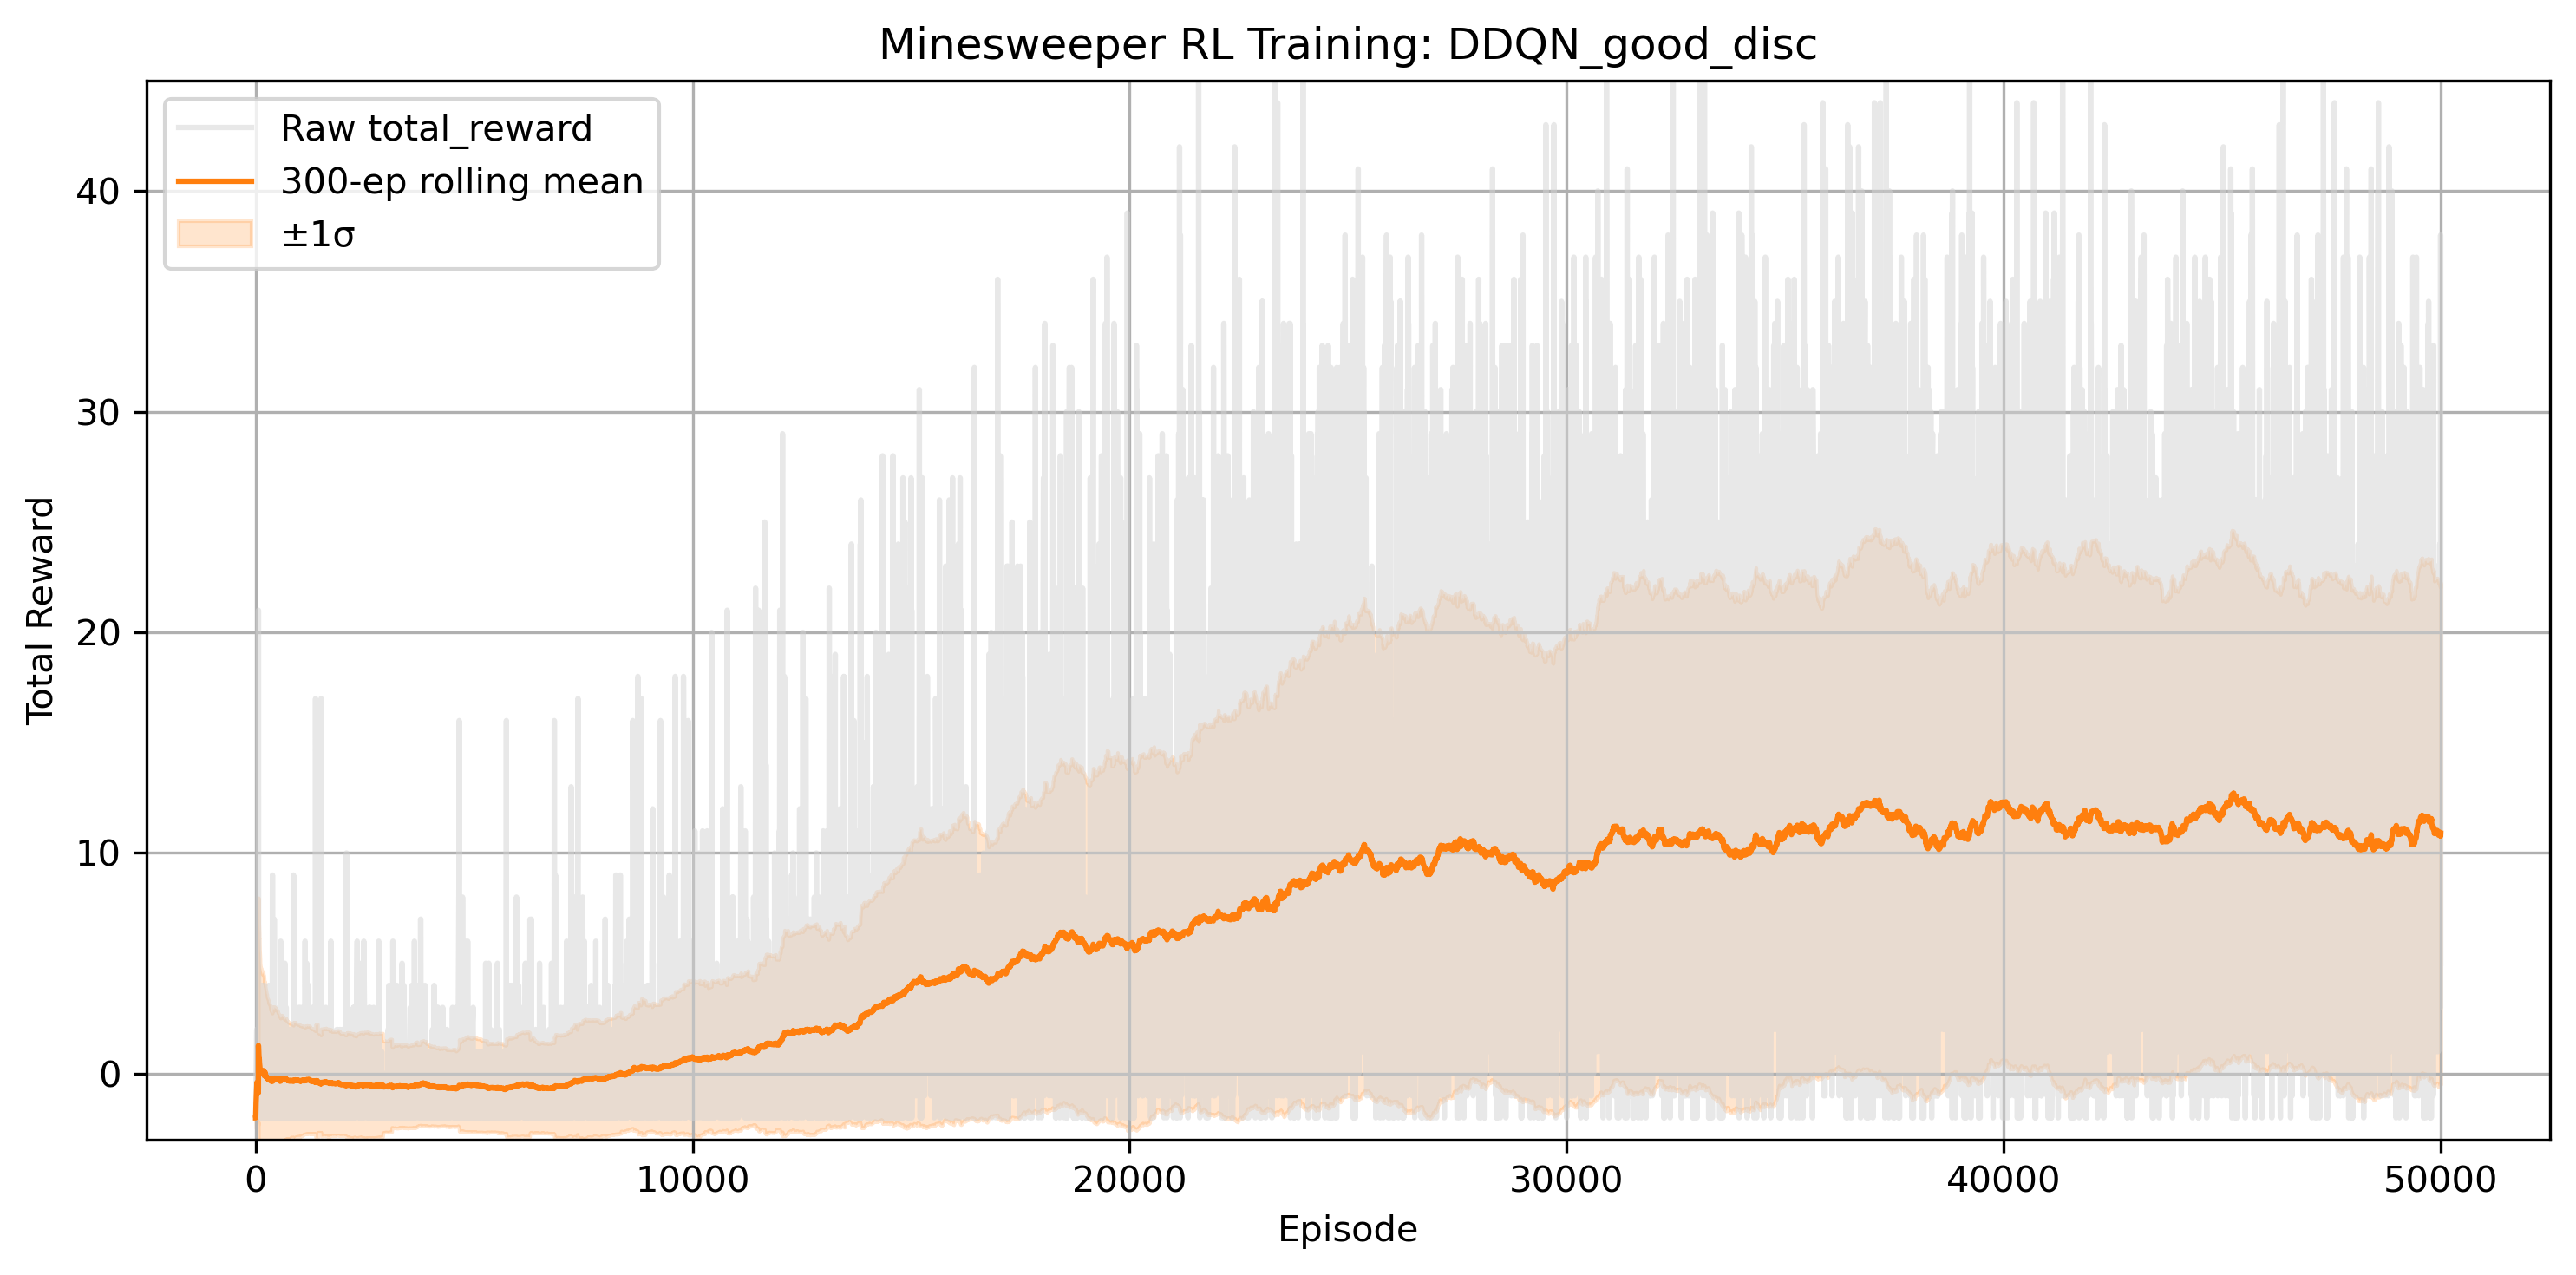

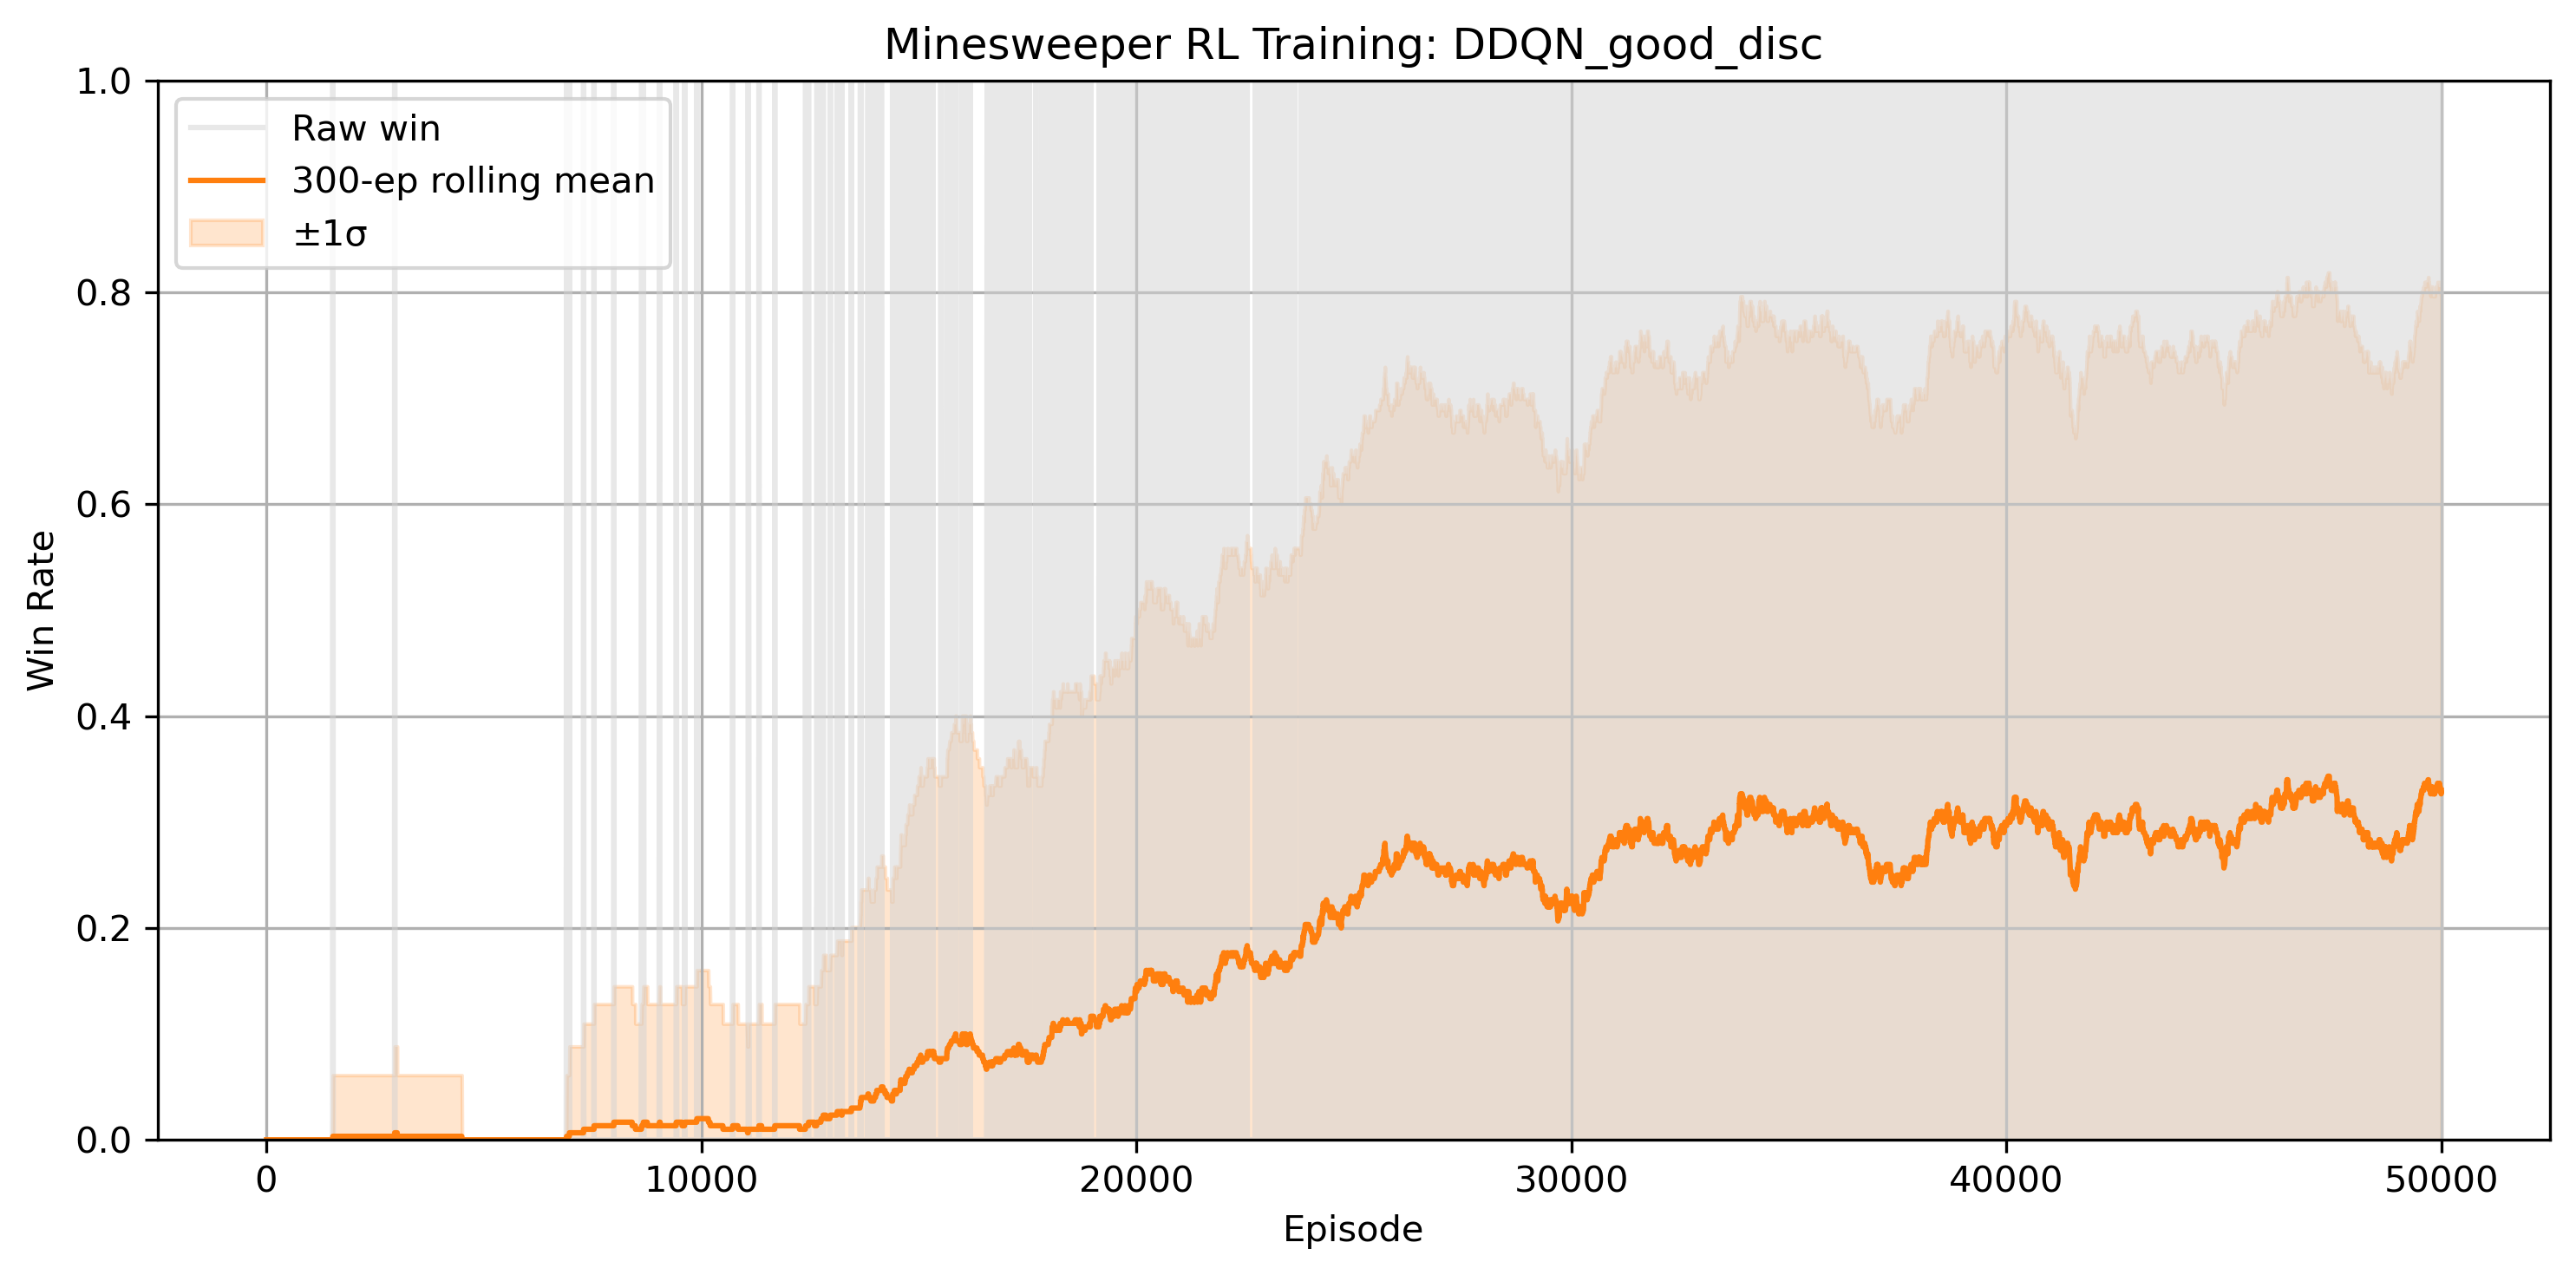

In [45]:
def plot_smoothed_curve(csv_path, target_metric, ylabel, title_prefix, window=300):
    import pandas as pd
    import matplotlib.pyplot as plt
    import re

    df = pd.read_csv(csv_path)

    pattern = re.compile(r'^(.*?) - (.*?)(?:__(MIN|MAX))?$')
    renamed_cols = {}
    model_name = None
    detected_column = None

    for col in df.columns:
        if col == 'Step':
            renamed_cols[col] = 'episode'
        else:
            match = pattern.match(col)
            if match:
                model, metric, suffix = match.groups()
                if model_name is None:
                    model_name = model
                base_name = metric
                new_name = f'{base_name}_{suffix.lower()}' if suffix else base_name
                renamed_cols[col] = new_name
                if suffix is None and metric == target_metric:
                    detected_column = new_name
            else:
                renamed_cols[col] = col

    df = df.rename(columns=renamed_cols)

    if detected_column is None:
        raise KeyError(f"Could not find a column for metric '{target_metric}'. Found columns: {list(df.columns)}")

    df['roll_mean'] = df[detected_column].rolling(window, min_periods=1).mean()
    df['roll_std']  = df[detected_column].rolling(window, min_periods=1).std().fillna(0)

    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(df['episode'], df[detected_column], color='lightgray', alpha=0.5, label=f'Raw {target_metric}')
    plt.plot(df['episode'], df['roll_mean'], color='C1', label=f'{window}-ep rolling mean')
    plt.fill_between(df['episode'],
                     df['roll_mean'] - df['roll_std'],
                     df['roll_mean'] + df['roll_std'],
                     color='C1', alpha=0.2, label='±1σ')
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.title(f'{title_prefix}: {model_name}')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Fixed y-axis limits
    if target_metric == "total_reward":
        plt.ylim(-3, 45)
    elif target_metric == "win":
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

parent_folder = "results/NonDet"  # ← change this to your target path

for folder_name in os.listdir(parent_folder):
    full_path = os.path.join(parent_folder, folder_name)
    if os.path.isdir(full_path):
        if folder_name == "Q_learning":
            continue
        plot_smoothed_curve(
            csv_path=f"{full_path}/t_reward.csv",
            target_metric="total_reward",
            ylabel="Total Reward",
            title_prefix="Minesweeper RL Training"
        )
        plot_smoothed_curve(
            csv_path=f"{full_path}/win.csv",
            target_metric="win",
            ylabel="Win Rate",
            title_prefix="Minesweeper RL Training"
        )

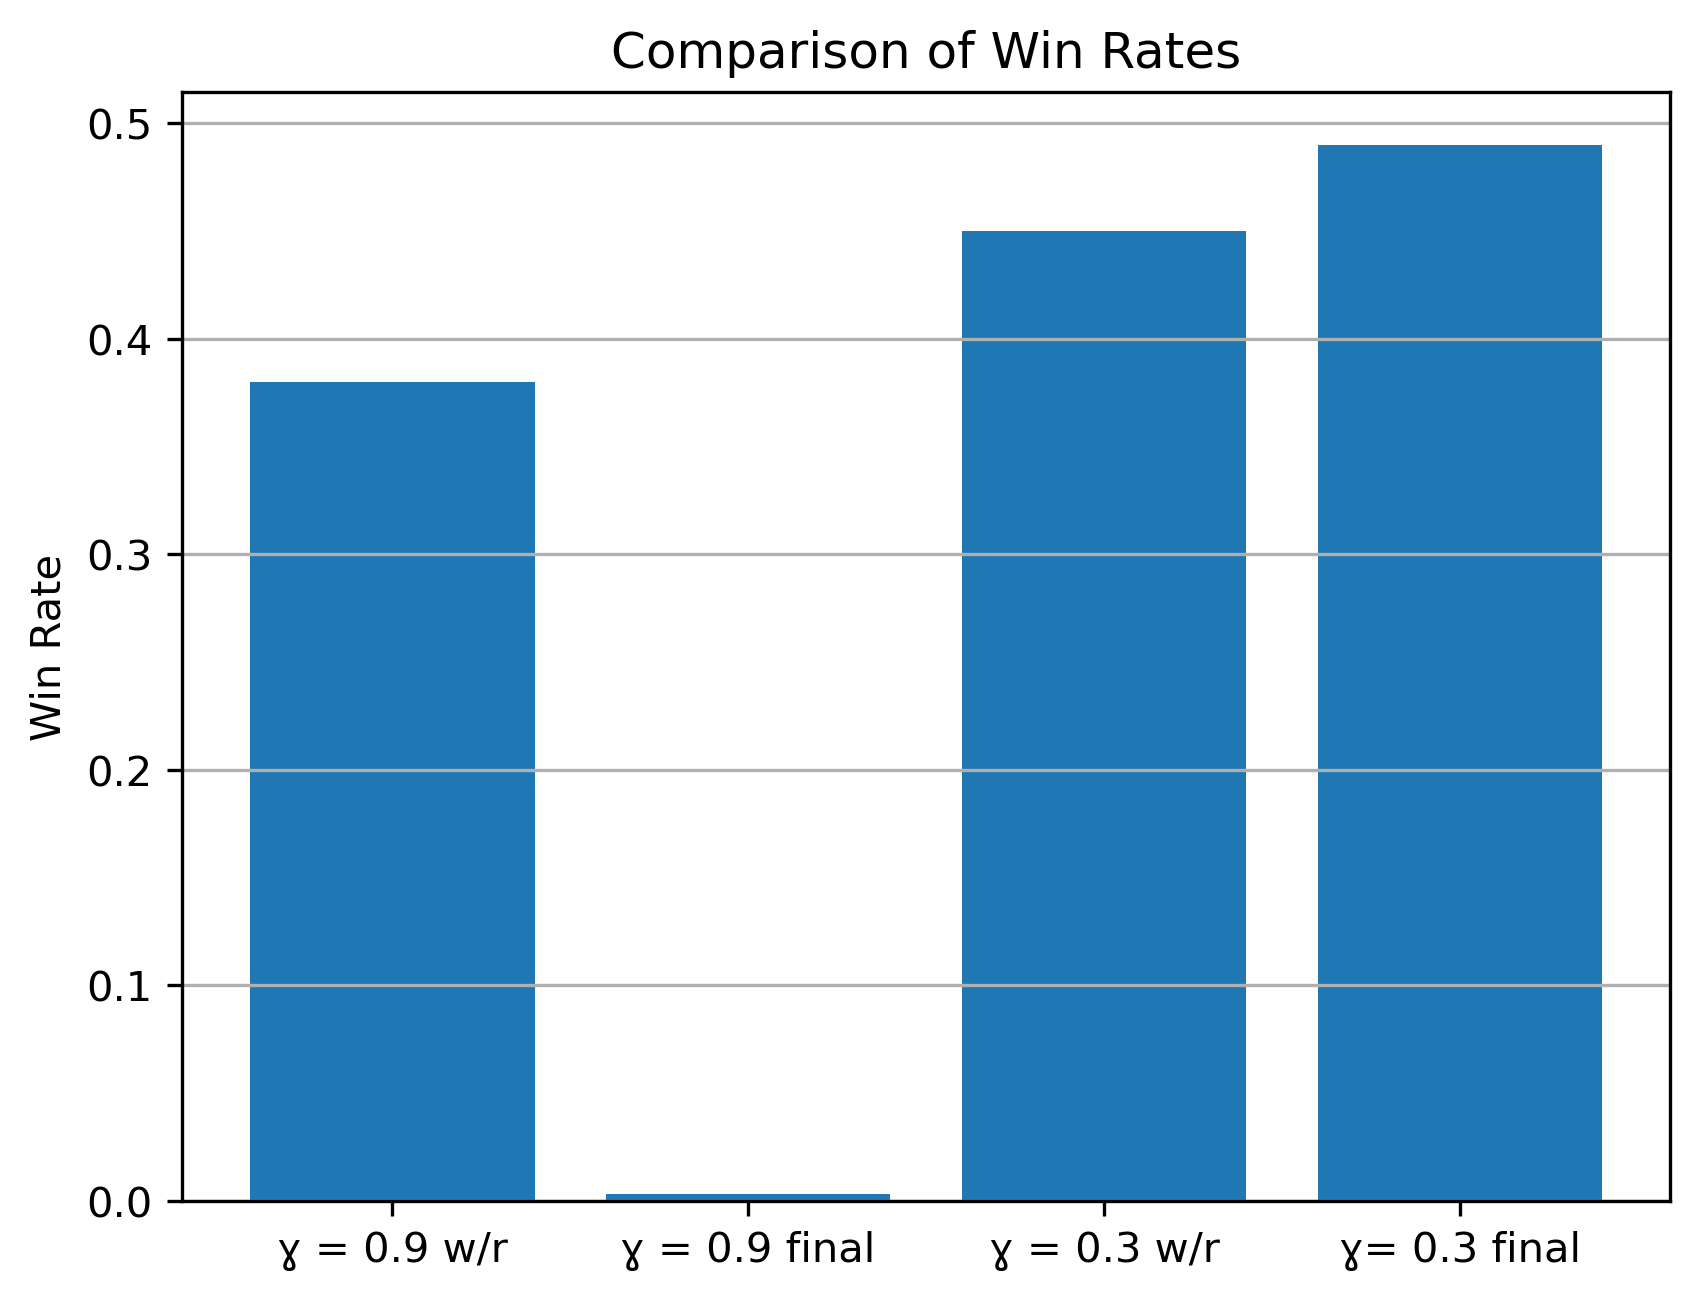

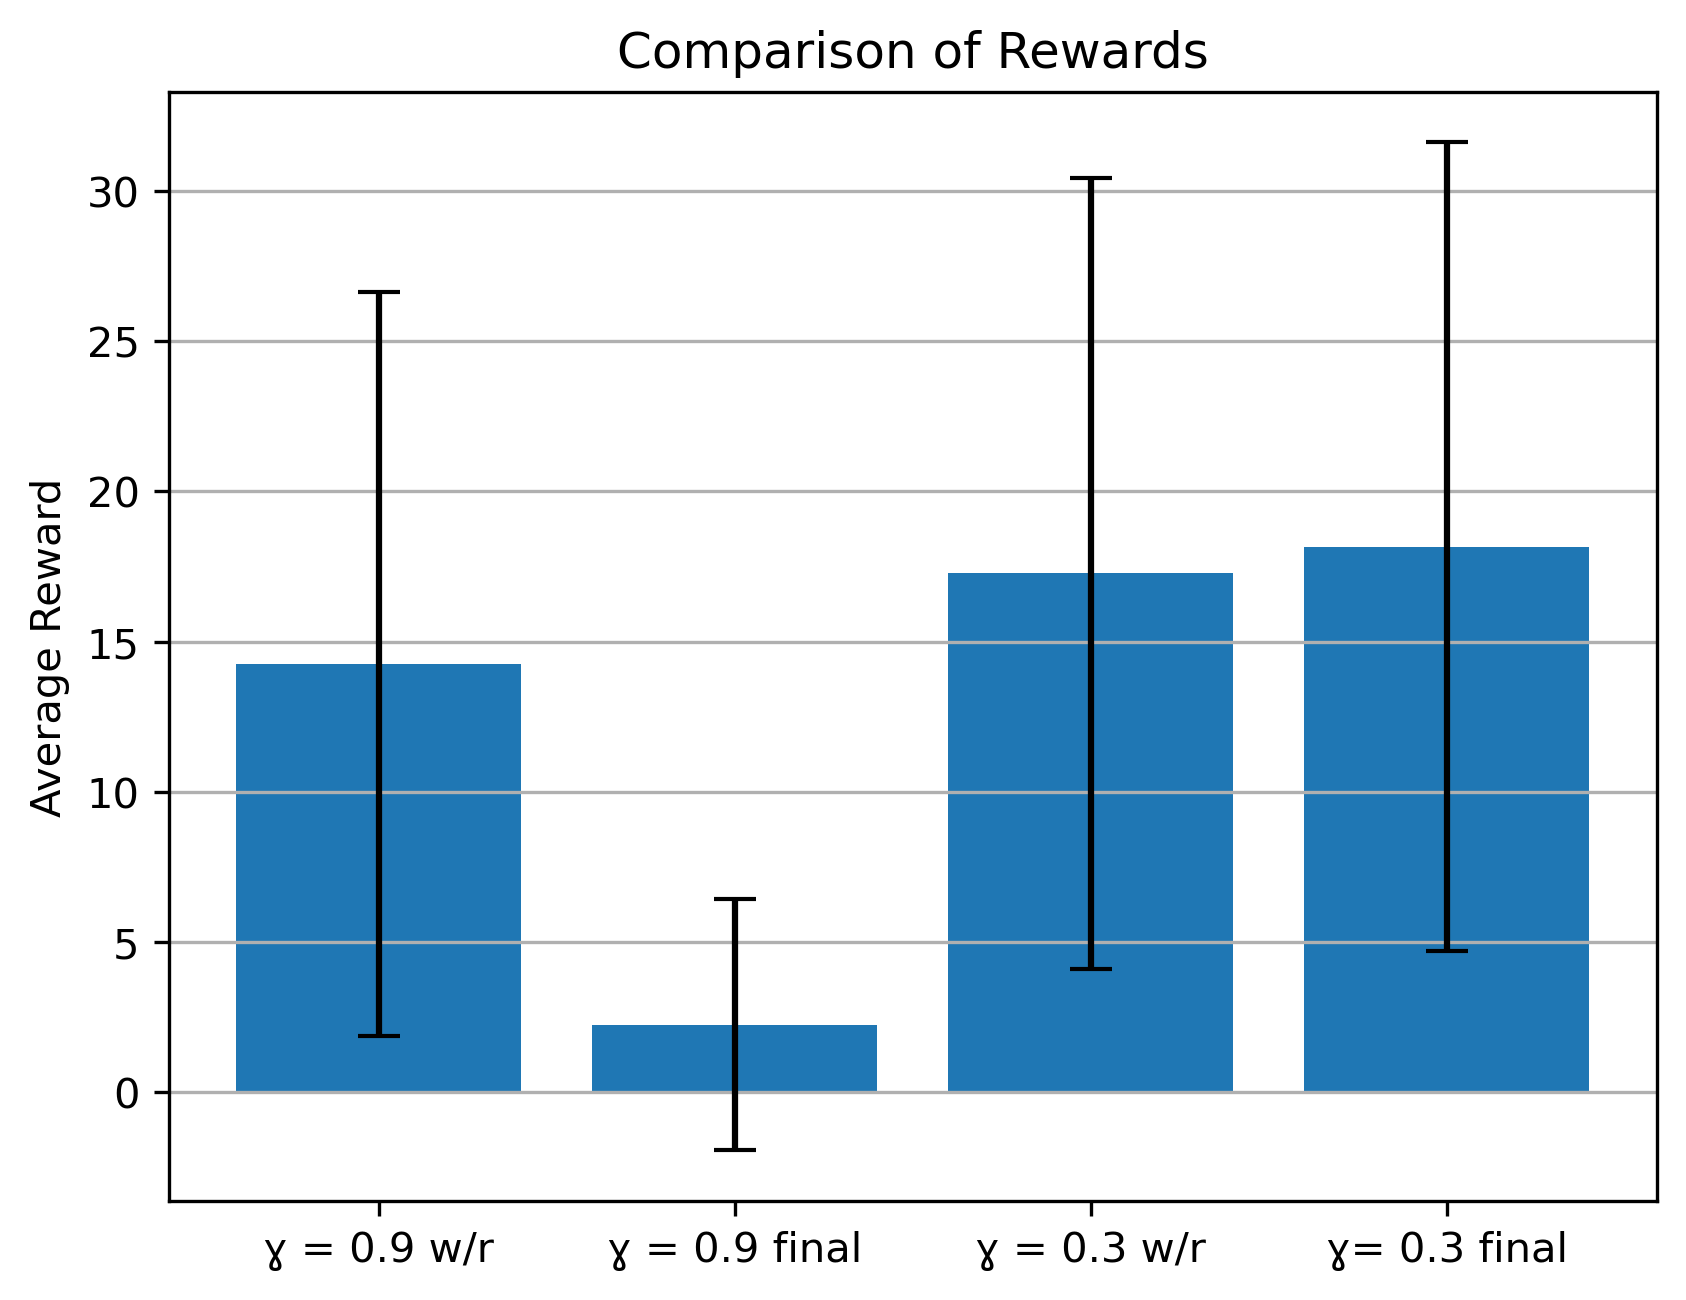

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual filenames
filenames = ["results/NonDet/DDQN_disc_0.9/eval_best_9_results.csv", 
             "results/NonDet/DDQN_disc_0.9/eval_final_9_results.csv", 
             "results/NonDet/DDQN_disc0.3/eval_best_3_results.csv", 
             "results/NonDet/DDQN_disc0.3/eval_final_3_results.csv"]
labels = ["ɣ = 0.9 w/r", 
          "​ɣ = 0.9 final",
          "​ɣ = 0.3 w/r",
          "​ɣ= 0.3 final"]

win_rates = []
win_std = []
rewards = []
reward_std = []

for fname in filenames:
    df = pd.read_csv(fname)
    
    win_rate = df["win"].mean()
    win_std_dev = df["win"].std()
    reward_avg = df["reward"].mean()
    reward_std_dev = df["reward"].std()
    
    win_rates.append(win_rate)
    win_std.append(win_std_dev)
    rewards.append(reward_avg)
    reward_std.append(reward_std_dev)

x = np.arange(len(labels))

# Plot Win Rate
plt.figure(dpi=300)
plt.bar(x, win_rates, capsize=5)
plt.xticks(x, labels)
plt.ylabel("Win Rate")
plt.title("Comparison of Win Rates")
plt.grid(axis='y')

# Plot Reward
plt.figure(dpi=300)
plt.bar(x, rewards, yerr=reward_std, capsize=5)
plt.xticks(x, labels)
plt.ylabel("Average Reward")
plt.title("Comparison of Rewards")
plt.grid(axis='y')

plt.show()
